In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import missingno as msno
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

## **Load Data and Analysis Basic Info**

In [28]:
df = pd.read_csv('../weather_data.csv', parse_dates=['date'])

# check the shape 
print("Dataset shape:", df.shape) 

print("\nFirst 5 rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nDescriptive statistics:")
print(df.describe())

Dataset shape: (311, 7)

First 5 rows:
        date  avg_temperature   humidity  avg_wind_speed rain_or_not  \
0 2023-01-01        23.745401  46.140905        7.845981        Rain   
1 2023-01-02        30.030503  59.876587        5.382457        Rain   
2 2023-01-03        28.365224  51.464618       13.158008        Rain   
3 2023-01-04        27.550929  53.103799        5.886677        Rain   
4 2023-01-05        23.639303  57.826186       12.248992        Rain   

   cloud_cover     pressure  
0    20.851051   992.965681  
1    93.059521  1037.273025  
2    11.636640  1034.193357  
3    81.744971   968.610142  
4    38.062329  1030.264331  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             311 non-null    datetime64[ns]
 1   avg_temperature  296 non-null    float64       
 2   humidity    

### **Analysis Basis Stats**

In [29]:

# Display basic statistics
print("\nBasic Statistics:")
print(df.describe())

print("\nDataset Info:")
df.info()



Basic Statistics:
                      date  avg_temperature    humidity  avg_wind_speed  \
count                  311       296.000000  296.000000      296.000000   
mean   2023-06-05 00:00:00        25.983840   55.041385        7.556636   
min    2023-01-01 00:00:00        15.000000   30.000000        0.069480   
25%    2023-03-19 12:00:00        20.265692   34.280826        3.550354   
50%    2023-06-05 00:00:00        27.177958   56.759806        7.326421   
75%    2023-08-21 12:00:00        32.204599   72.189837       11.050627   
max    2023-11-07 00:00:00        35.000000   90.000000       56.636041   
std                    NaN         6.802475   19.220133        5.344683   

       cloud_cover     pressure  
count   296.000000   311.000000  
mean     49.834827  1001.059119  
min       0.321826   951.240404  
25%      24.530951   975.757545  
50%      50.725120  1001.938586  
75%      76.046506  1026.578884  
max      99.834751  1049.543752  
std      29.009459    28.835595  

**There are some missing values in the dataset Let's analysis them.**

In [30]:
print("\nMissing values in each column:")
print(df.isnull().sum())
plt.figure(figsize=(10, 6))
msno.matrix(df)
plt.title('Missing Value Patterns')
plt.savefig('missing_values.png')
plt.close()


Missing values in each column:
date                0
avg_temperature    15
humidity           15
avg_wind_speed     15
rain_or_not         0
cloud_cover        15
pressure            0
dtype: int64


<Figure size 1000x600 with 0 Axes>

## **Data Preprocessing**
### **Missing Value Analysis**

<Figure size 1000x600 with 0 Axes>

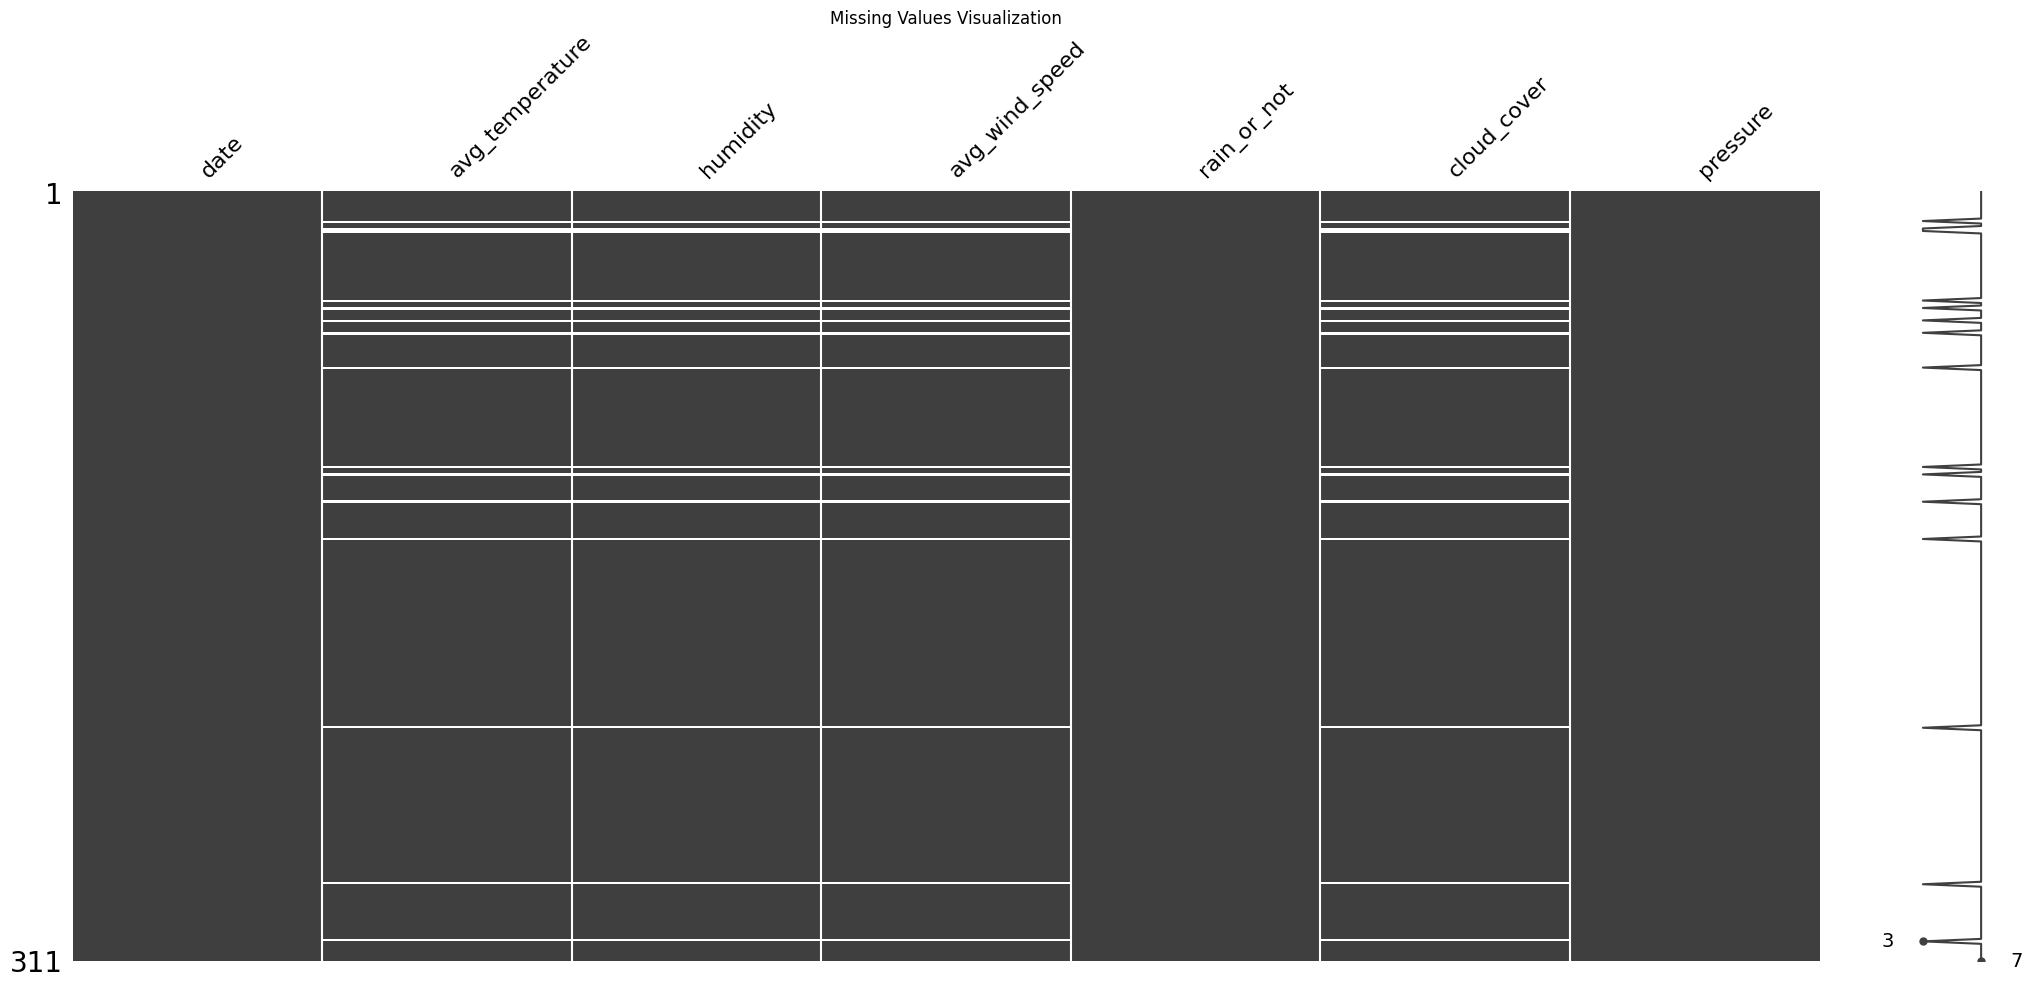

In [31]:
# Load the weather dataset with date parsing

weather_df = pd.read_csv('../weather_data.csv',   # load data set again before analysis the missing values
                         parse_dates=['date'],  # Replace with actual date column name
                         infer_datetime_format=True)


# Visualize missing values using missingno
plt.figure(figsize=(10, 6))
msno.matrix(weather_df)
plt.title('Missing Values Visualization')
plt.tight_layout()
plt.show()

# Time series plot (if data contains temperature or similar measurements)
if 'temperature' in weather_df.columns: 
    plt.figure(figsize=(12, 6))
    weather_df.set_index('date').temperature.plot()
    plt.title('Temperature Over Time')
    plt.ylabel('Temperature')
    plt.tight_layout()
    plt.show()

### **Date column Analysis(Anomalies and Dublications)**

In [32]:
# Handle date formatting issues
# Ensure dates are in proper datetime format
weather_df['date'] = pd.to_datetime(weather_df['date'], errors='coerce')

# Check for NaT (Not a Time) values which indicate parsing failures
if weather_df['date'].isnull().any():
    print(f"\nFound {weather_df['date'].isnull().sum()} invalid date entries")
    # Drop rows with invalid dates or replace with neighboring dates
    weather_df = weather_df.dropna(subset=['date'])
    
# Sort by date to ensure chronological order
weather_df = weather_df.sort_values('date').reset_index(drop=True)

print("\nDate range in dataset:")
print(f"Start: {weather_df['date'].min()}, End: {weather_df['date'].max()}")

# Check for gaps in the time series
date_diff = weather_df['date'].diff().dropna()
print("\nTime intervals between records:")
print(date_diff.value_counts().sort_index().head())

# Check if we have regular daily data
is_daily = (date_diff == timedelta(days=1)).all()
print(f"\nData has regular daily intervals: {is_daily}")

# Add date components for time series analysis
weather_df['year'] = weather_df['date'].dt.year
weather_df['month'] = weather_df['date'].dt.month
weather_df['day'] = weather_df['date'].dt.day
weather_df['day_of_week'] = weather_df['date'].dt.dayofweek
weather_df['day_name'] = weather_df['date'].dt.day_name()
weather_df['is_weekend'] = weather_df['day_of_week'].isin([5, 6]).astype(int)

print("\nDate components added to dataset:")
display(weather_df[['date', 'year', 'month', 'day', 'day_name', 'is_weekend']].head())


Date range in dataset:
Start: 2023-01-01 00:00:00, End: 2023-11-07 00:00:00

Time intervals between records:
date
1 days    310
Name: count, dtype: int64

Data has regular daily intervals: True

Date components added to dataset:


,date,year,month,day,day_name,is_weekend
0,2023-01-01,2023,1,1,Sunday,1
1,2023-01-02,2023,1,2,Monday,0
2,2023-01-03,2023,1,3,Tuesday,0
3,2023-01-04,2023,1,4,Wednesday,0
4,2023-01-05,2023,1,5,Thursday,0


In [33]:
# Check for duplicate date entries
duplicates = weather_df[weather_df.duplicated(subset=['date'], keep=False)]

if len(duplicates) > 0:
    print(f"\nFound {len(duplicates)} duplicate date entries:")
    display(duplicates.sort_values('date'))
    
    # Option 1: Keep the first occurrence
    weather_df_dedup1 = weather_df.drop_duplicates(subset=['date'], keep='first')
    print(f"\nDataset size after removing duplicates (keeping first): {weather_df_dedup1.shape}")
    
    # Option 2: Average values for same dates
    weather_df_dedup2 = weather_df.groupby('date').mean(numeric_only=True).reset_index()
    
    # Restore non-numeric columns that might have been dropped during mean operation
    if 'rain_or_not' in weather_df.columns:
        # For categorical columns like 'rain_or_not', take the most common value for each date
        rain_mode = weather_df.groupby('date')['rain_or_not'].agg(lambda x: x.mode()[0]).reset_index()
        weather_df_dedup2 = weather_df_dedup2.merge(rain_mode, on='date')
    
    print(f"Dataset size after aggregating duplicates: {weather_df_dedup2.shape}")
    
    # Choose which deduplication method to use
    weather_df = weather_df_dedup1  # Change to weather_df_dedup2 if preferred
    
    print("\nChosen deduplication method: keeping first occurrence")
else:
    print("\nNo duplicate dates found in the dataset.")

# Verify there are no more duplicates
assert not weather_df.duplicated(subset=['date']).any(), "Duplicates still exist!"
print("Duplicate dates have been successfully handled.")

# Summary statistics for deduplicated data
print("\nSummary statistics after handling duplicates:")
print(weather_df[['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']].describe())


No duplicate dates found in the dataset.
Duplicate dates have been successfully handled.

Summary statistics after handling duplicates:
       avg_temperature    humidity  avg_wind_speed  cloud_cover     pressure
count       296.000000  296.000000      296.000000   296.000000   311.000000
mean         25.983840   55.041385        7.556636    49.834827  1001.059119
std           6.802475   19.220133        5.344683    29.009459    28.835595
min          15.000000   30.000000        0.069480     0.321826   951.240404
25%          20.265692   34.280826        3.550354    24.530951   975.757545
50%          27.177958   56.759806        7.326421    50.725120  1001.938586
75%          32.204599   72.189837       11.050627    76.046506  1026.578884
max          35.000000   90.000000       56.636041    99.834751  1049.543752


### **Handle the Missing Values**

In [34]:
# Make a copy of the dataframe before imputation for comparison
weather_df_before = weather_df.copy()

# Check missing values before imputation
print("Missing values before imputation:")
print(weather_df.isnull().sum())

# For temperature, use time-based interpolation
if weather_df['avg_temperature'].isnull().any():
    # Set 'date' as the index for time-based interpolation
    weather_df.set_index('date', inplace=True)
    # Since your data is already sorted by date, time-based interpolation will work well
    weather_df['avg_temperature'] = weather_df['avg_temperature'].interpolate(method='time')
    # Reset the index back to default
    weather_df.reset_index(inplace=True)
    print("\nInterpolated missing temperature values based on time")

# For humidity, wind speed, and cloud cover, use KNN imputation
num_cols = ['humidity', 'avg_wind_speed', 'cloud_cover']
if weather_df[num_cols].isnull().any().any():
    # Scale the data before KNN imputation for better results
    scaler = StandardScaler()
    # Get indices of rows with nulls
    null_indices = weather_df[weather_df[num_cols].isnull().any(axis=1)].index
    
    # Create a copy of needed columns for imputation
    impute_df = weather_df[['avg_temperature'] + num_cols].copy()
    # Apply KNN imputation
    knn_imputer = KNNImputer(n_neighbors=5)
    imputed_data = knn_imputer.fit_transform(impute_df)
    
    # Replace only the missing values with the imputed values
    weather_df.loc[:, num_cols] = imputed_data[:, 1:]
    print(f"\nApplied KNN imputation with 5 neighbors for {', '.join(num_cols)}")

# For any remaining missing values in numeric columns, use median imputation
num_cols_all = ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']
if weather_df[num_cols_all].isnull().any().any():
    median_imputer = SimpleImputer(strategy='median')
    weather_df[num_cols_all] = median_imputer.fit_transform(weather_df[num_cols_all])
    print("\nApplied median imputation for any remaining missing values")

# If target column has missing values, we might want to drop those rows
if weather_df['rain_or_not'].isnull().any():
    before_count = len(weather_df)
    weather_df = weather_df.dropna(subset=['rain_or_not'])
    print(f"\nDropped {before_count - len(weather_df)} rows with missing target values")

print("\nAfter imputation, missing values:")
print(weather_df.isnull().sum())



Missing values before imputation:
date                0
avg_temperature    15
humidity           15
avg_wind_speed     15
rain_or_not         0
cloud_cover        15
pressure            0
year                0
month               0
day                 0
day_of_week         0
day_name            0
is_weekend          0
dtype: int64

Interpolated missing temperature values based on time

Applied KNN imputation with 5 neighbors for humidity, avg_wind_speed, cloud_cover

After imputation, missing values:
date               0
avg_temperature    0
humidity           0
avg_wind_speed     0
rain_or_not        0
cloud_cover        0
pressure           0
year               0
month              0
day                0
day_of_week        0
day_name           0
is_weekend         0
dtype: int64


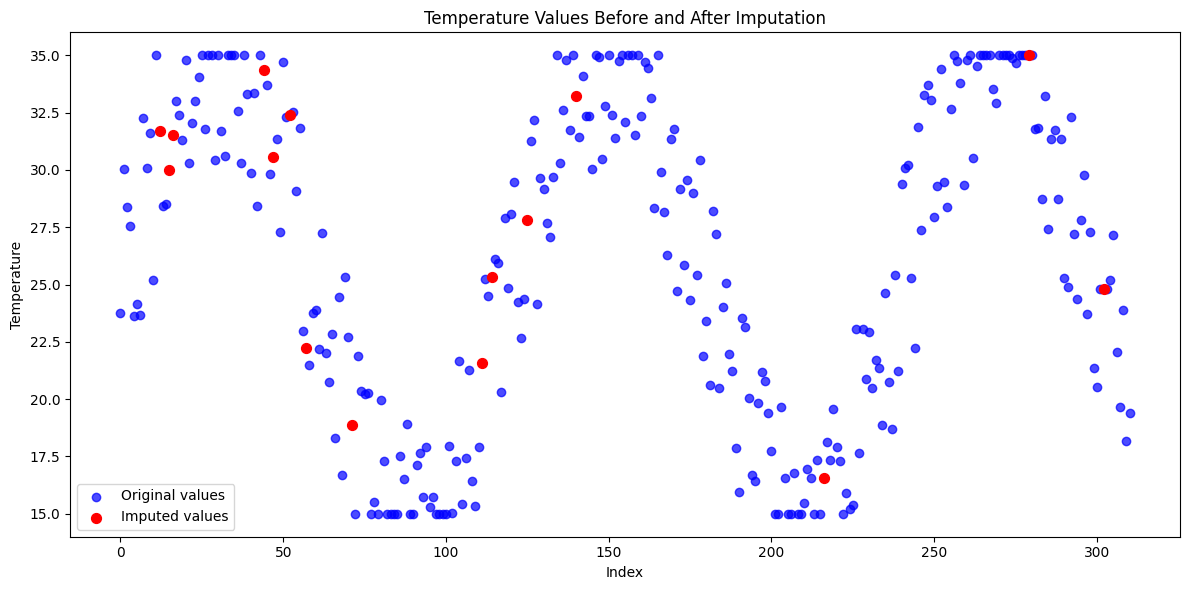

In [16]:
# Visualize the imputation results for temperature
if 'avg_temperature' in weather_df.columns:
    plt.figure(figsize=(12, 6))
    
    # Plot original data with missing values
    plt.scatter(weather_df_before.index, weather_df_before['avg_temperature'], 
                color='blue', label='Original values', alpha=0.7)
    
    # Highlight imputed values
    imputed_idx = weather_df_before['avg_temperature'].isnull()
    plt.scatter(weather_df.index[imputed_idx], weather_df.loc[imputed_idx, 'avg_temperature'], 
                color='red', s=50, label='Imputed values')
    
    plt.title('Temperature Values Before and After Imputation')
    plt.xlabel('Index')
    plt.ylabel('Temperature')
    plt.legend()
    plt.tight_layout()
    plt.show()



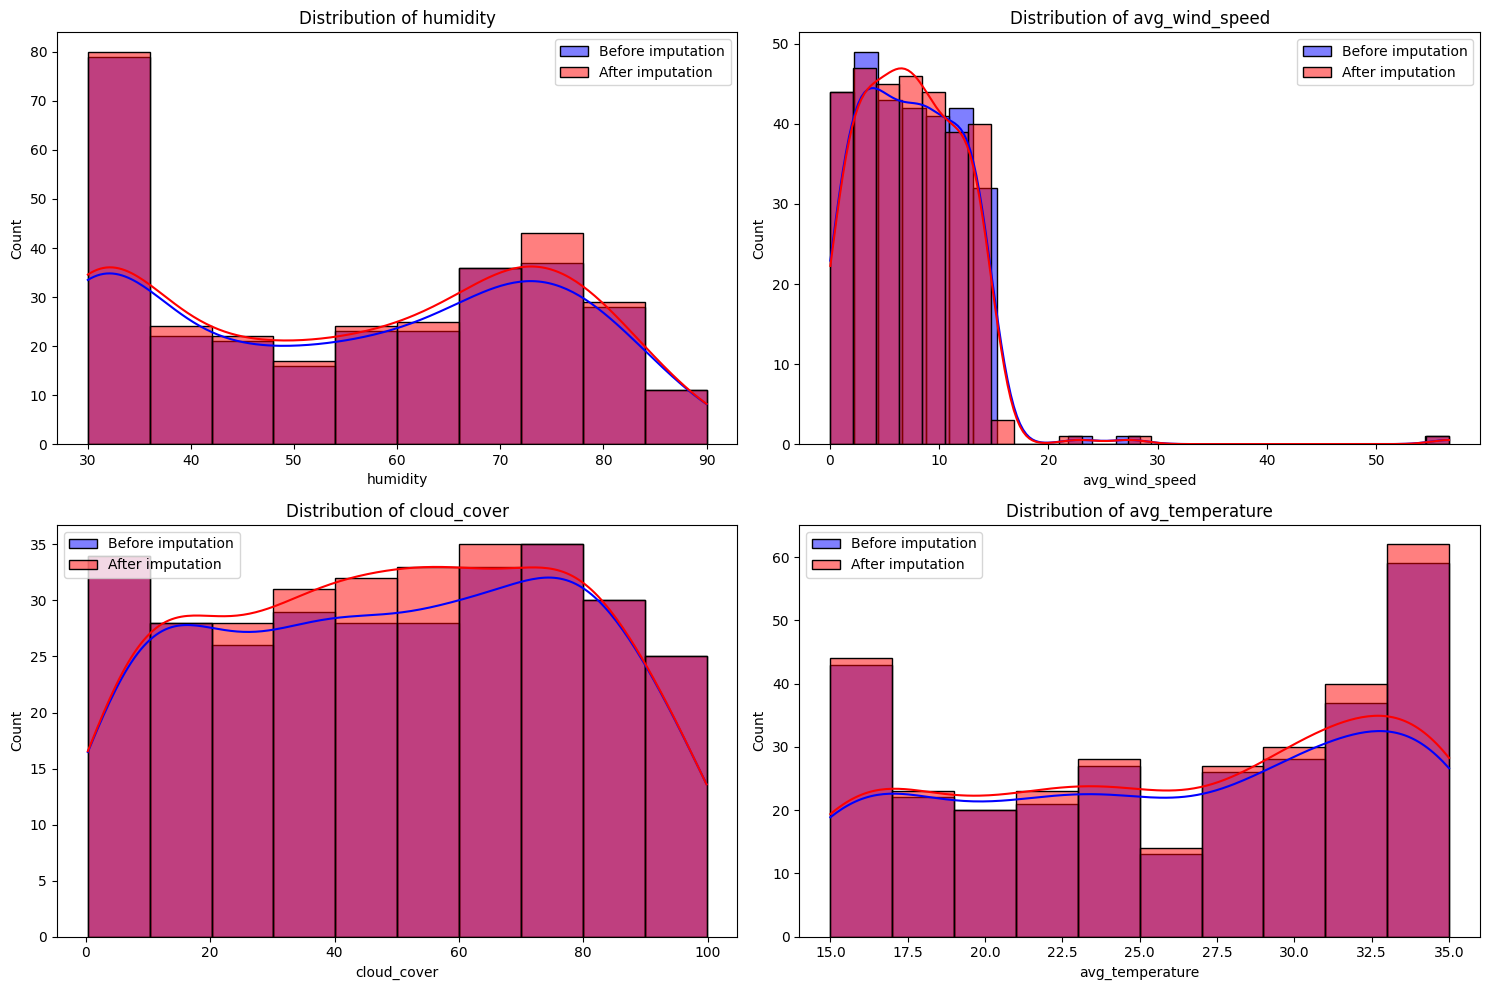

In [35]:
# Compare distributions before and after imputation
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols + ['avg_temperature']):
    plt.subplot(2, 2, i+1)
    
    # Plot histograms
    sns.histplot(weather_df_before[col].dropna(), color='blue', alpha=0.5, label='Before imputation', kde=True)
    sns.histplot(weather_df[col], color='red', alpha=0.5, label='After imputation', kde=True)
    
    plt.title(f'Distribution of {col}')
    plt.legend()

plt.tight_layout()
plt.show()



In [36]:
# Save the cleaned dataset
weather_df.to_csv('../Data-Set/processed_data/weather_data_cleaned.csv', index=False)
print("\nCleaned dataset saved as 'weather_data_cleaned.csv'")


Cleaned dataset saved as 'weather_data_cleaned.csv'


In [37]:
display(weather_df.iloc[248]) 

date               2023-09-06 00:00:00
avg_temperature              33.703566
humidity                     60.261753
avg_wind_speed               11.563683
rain_or_not                    No Rain
cloud_cover                  44.861063
pressure                    996.876797
year                              2023
month                                9
day                                  6
day_of_week                          2
day_name                     Wednesday
is_weekend                           0
Name: 248, dtype: object

In [38]:
# List all numeric columns that should be float type
numeric_cols = ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']

# Display original data types
print("Original data types:")
print(weather_df.dtypes)

# Ensure numeric columns are actually numeric
for col in numeric_cols:
    if col in weather_df.columns:
        # Store count of values before conversion to track any lost data
        values_before = weather_df[col].count()
        
        # Convert to numeric, setting invalid values to NaN
        weather_df[col] = pd.to_numeric(weather_df[col], errors='coerce')
        
        # Check if we lost any values during conversion
        values_after = weather_df[col].count()
        if values_before > values_after:
            print(f"Warning: Lost {values_before - values_after} values when converting {col} to numeric")



Original data types:
date               datetime64[ns]
avg_temperature           float64
humidity                  float64
avg_wind_speed            float64
rain_or_not                object
cloud_cover               float64
pressure                  float64
year                        int32
month                       int32
day                         int32
day_of_week                 int32
day_name                   object
is_weekend                  int32
dtype: object


In [39]:
display(weather_df.iloc[248]) 

date               2023-09-06 00:00:00
avg_temperature              33.703566
humidity                     60.261753
avg_wind_speed               11.563683
rain_or_not                    No Rain
cloud_cover                  44.861063
pressure                    996.876797
year                              2023
month                                9
day                                  6
day_of_week                          2
day_name                     Wednesday
is_weekend                           0
Name: 248, dtype: object

### **Handle the Outliers**

In [40]:
# Create a copy of the dataframe to preserve original values for comparison
weather_df_original = weather_df.copy()

def cap_outliers(df, col, method='iqr', threshold=1.5, visualize=True):
    """
    Identify and cap outliers in a given column
    
    Parameters:
    -----------
    df : pandas DataFrame
    col : str, column name
    method : str, 'iqr' or 'zscore'
    threshold : float, multiplier for IQR or number of std deviations
    visualize : bool, whether to visualize before and after
    
    Returns:
    --------
    df : pandas DataFrame with outliers capped
    """
    # For plotting before/after
    values_before = df[col].copy()
    
    if method == 'iqr':
        # Calculate IQR bounds
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
    elif method == 'zscore':
        # Calculate z-score bounds
        mean = df[col].mean()
        std = df[col].std()
        lower_bound = mean - threshold * std
        upper_bound = mean + threshold * std
    else:
        raise ValueError("Method must be 'iqr' or 'zscore'")
    
    # Count outliers before capping
    outliers_low = (df[col] < lower_bound).sum()
    outliers_high = (df[col] > upper_bound).sum()
    total_outliers = outliers_low + outliers_high
    
    if total_outliers > 0:
        print(f"Capping {total_outliers} outliers in {col} ({outliers_low} low, {outliers_high} high)")
        print(f"  - Range before capping: [{df[col].min():.2f}, {df[col].max():.2f}]")
        
        # Cap the outliers
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
        
        print(f"  - Range after capping: [{df[col].min():.2f}, {df[col].max():.2f}]")
        print(f"  - Bounds used: [{lower_bound:.2f}, {upper_bound:.2f}]")
    else:
        print(f"No outliers found in {col}")
    
    # Visualize before and after (optional)
    if visualize and total_outliers > 0:
        plt.figure(figsize=(12, 5))
        
        # Before capping boxplot
        plt.subplot(1, 2, 1)
        sns.boxplot(x=values_before)
        plt.title(f'Before Outlier Treatment: {col}')
        
        # After capping boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col])
        plt.title(f'After Outlier Treatment: {col}')
        
        plt.tight_layout()
        plt.show()
        
        # Distribution before and after
        plt.figure(figsize=(10, 6))
        sns.kdeplot(values_before, label='Before capping', color='blue')
        sns.kdeplot(df[col], label='After capping', color='red')
        plt.title(f'Distribution Before and After Outlier Treatment: {col}')
        plt.legend()
        plt.show()
    
    return df




Outlier Treatment Results:
No outliers found in avg_temperature
No outliers found in humidity
Capping 2 outliers in avg_wind_speed (0 low, 2 high)
  - Range before capping: [0.07, 56.64]
  - Range after capping: [0.07, 25.32]
  - Bounds used: [-10.73, 25.32]


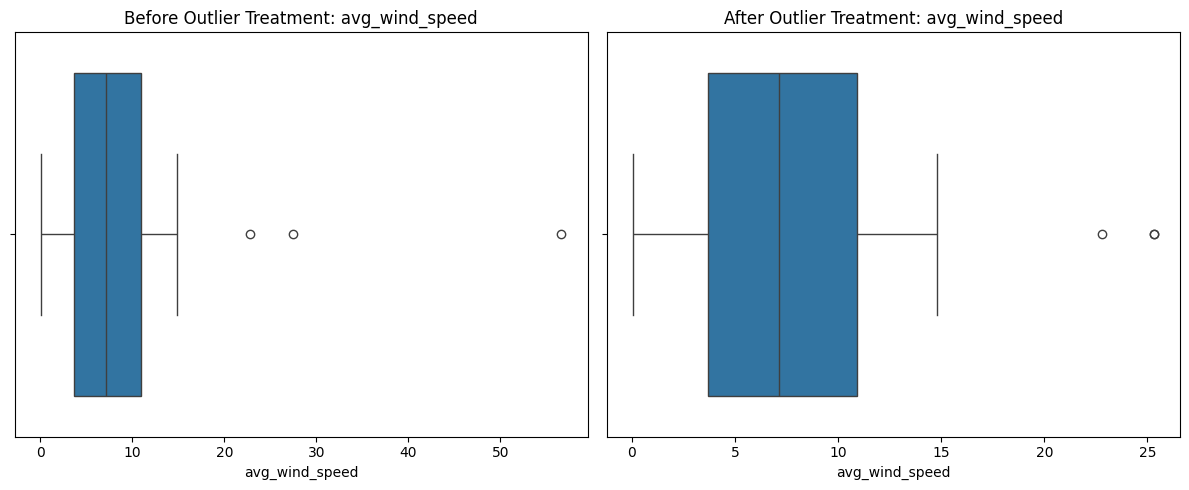

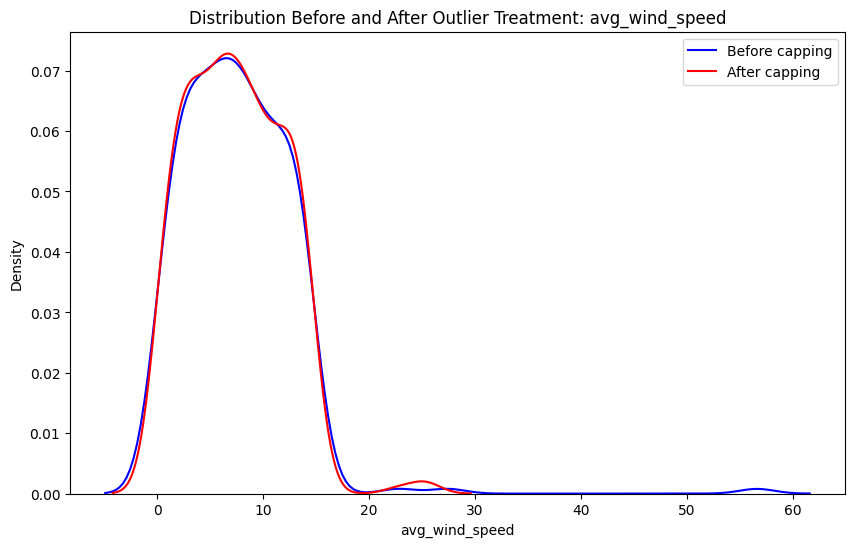

No outliers found in cloud_cover
No outliers found in pressure


In [41]:
# Define columns for outlier treatment
numeric_cols = ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']

# Apply outlier capping to each numeric feature
print("\nOutlier Treatment Results:")
for col in numeric_cols:
    if col in weather_df.columns:
        # You can customize settings for each column if needed
        if col == 'avg_wind_speed':
            # Wind speed might have more legitimate extreme values
            weather_df = cap_outliers(weather_df, col, threshold=2.0)
        else:
            weather_df = cap_outliers(weather_df, col)



In [42]:
# Summarize the impact of outlier treatment
print("\nImpact Summary of Outlier Treatment:")
for col in numeric_cols:
    if col in weather_df.columns:
        # Calculate statistics to see the impact
        orig_std = weather_df_original[col].std()
        new_std = weather_df[col].std()
        std_change = (orig_std - new_std) / orig_std * 100
        
        print(f"{col}:")
        print(f"  - Standard deviation before: {orig_std:.2f}, after: {new_std:.2f}")
        print(f"  - Reduction in variability: {std_change:.2f}%")


Impact Summary of Outlier Treatment:
avg_temperature:
  - Standard deviation before: 6.76, after: 6.76
  - Reduction in variability: 0.00%
humidity:
  - Standard deviation before: 19.09, after: 19.09
  - Reduction in variability: 0.00%
avg_wind_speed:
  - Standard deviation before: 5.23, after: 4.51
  - Reduction in variability: 13.79%
cloud_cover:
  - Standard deviation before: 28.44, after: 28.44
  - Reduction in variability: 0.00%
pressure:
  - Standard deviation before: 28.84, after: 28.84
  - Reduction in variability: 0.00%


## **Feature Engineering**

### **Create Time Based Features**

In [43]:
# Extract basic date components
weather_df['day_of_week'] = weather_df['date'].dt.dayofweek  # Monday=0, Sunday=6
weather_df['month'] = weather_df['date'].dt.month
weather_df['day'] = weather_df['date'].dt.day
weather_df['is_weekend'] = weather_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Add day name for easier interpretation
weather_df['day_name'] = weather_df['date'].dt.day_name()

# Add seasonal features
weather_df['season'] = weather_df['month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else
                                           'Spring' if x in [3, 4, 5] else
                                           'Summer' if x in [6, 7, 8] else 'Fall')
# One-hot encode season
weather_df = pd.get_dummies(weather_df, columns=['season'], prefix='season')

# Add cyclical features for month and day of week
# These better capture the circular nature of time
weather_df['month_sin'] = np.sin(2 * np.pi * weather_df['month']/12.0)
weather_df['month_cos'] = np.cos(2 * np.pi * weather_df['month']/12.0)
weather_df['day_of_week_sin'] = np.sin(2 * np.pi * weather_df['day_of_week']/7.0)
weather_df['day_of_week_cos'] = np.cos(2 * np.pi * weather_df['day_of_week']/7.0)

# Add quarter of year
weather_df['quarter'] = weather_df['date'].dt.quarter

# Create week of year feature
weather_df['week_of_year'] = weather_df['date'].dt.isocalendar().week

# Display the first few rows with the new features
print("\nFirst 5 rows with date-based features:")
display(weather_df.head())




First 5 rows with date-based features:


,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure,year,month,day,...,season_Fall,season_Spring,season_Summer,season_Winter,month_sin,month_cos,day_of_week_sin,day_of_week_cos,quarter,week_of_year
0,2023-01-01,23.745401,46.140905,7.845981,Rain,20.851051,992.965681,2023,1,1,...,False,False,False,True,0.5,0.866025,-0.781831,0.623490,1,52
1,2023-01-02,30.030503,59.876587,5.382457,Rain,93.059521,1037.273025,2023,1,2,...,False,False,False,True,0.5,0.866025,0.000000,1.000000,1,1
2,2023-01-03,28.365224,51.464618,13.158008,Rain,11.636640,1034.193357,2023,1,3,...,False,False,False,True,0.5,0.866025,0.781831,0.623490,1,1
3,2023-01-04,27.550929,53.103799,5.886677,Rain,81.744971,968.610142,2023,1,4,...,False,False,False,True,0.5,0.866025,0.974928,-0.222521,1,1
4,2023-01-05,23.639303,57.826186,12.248992,Rain,38.062329,1030.264331,2023,1,5,...,False,False,False,True,0.5,0.866025,0.433884,-0.900969,1,1


### **Encode the Rain State**

In [44]:
# Convert rain_or_not from categorical to binary
if 'rain_or_not' in weather_df.columns:
    if weather_df['rain_or_not'].dtype == 'object':
        # Map string values to binary - FIXED to match your actual data values
        rain_mapping = {'Rain': 1, 'No Rain': 0}
        
        # Check for unexpected values before mapping
        unique_values = set(weather_df['rain_or_not'].unique())
        expected_values = set(rain_mapping.keys())
        unexpected = unique_values - expected_values
        
        if unexpected:
            print(f"Warning: Found unexpected values in rain_or_not: {unexpected}")
            # Handle unexpected values (could map to NaN or most common value)
            for val in unexpected:
                weather_df['rain_or_not'].replace(val, np.nan, inplace=True)
        
        # Apply mapping and convert to integer
        weather_df['rain_or_not'] = weather_df['rain_or_not'].map(rain_mapping)
    
    # Ensure it's integer type (even if already numeric)
    weather_df['rain_or_not'] = weather_df['rain_or_not'].astype(int)
    print("\nConverted rain_or_not to binary integer (1=Rain, 0=No Rain)")

    # Verify the conversion worked correctly
print("\nUnique values in rain_or_not after conversion:")
print(weather_df['rain_or_not'].unique())


Converted rain_or_not to binary integer (1=Rain, 0=No Rain)

Unique values in rain_or_not after conversion:
[1 0]


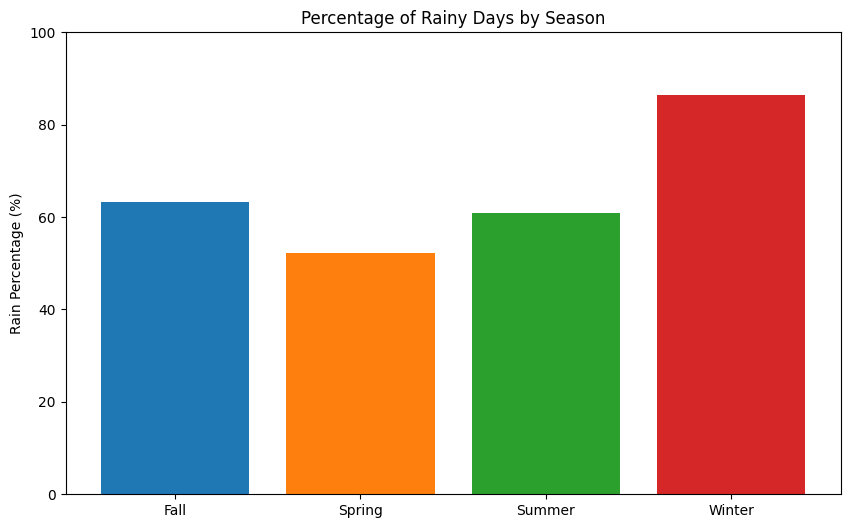

In [45]:
# Visualize distribution of rain by season
plt.figure(figsize=(10, 6))
if 'rain_or_not' in weather_df.columns:
    season_cols = [col for col in weather_df.columns if col.startswith('season_')]
    for season in season_cols:
        season_name = season.replace('season_', '')
        rain_pct = weather_df[weather_df[season] == 1]['rain_or_not'].mean() * 100
        plt.bar(season_name, rain_pct)
    
    plt.title('Percentage of Rainy Days by Season')
    plt.ylabel('Rain Percentage (%)')
    plt.ylim(0, 100)
    plt.show()

### **Create Window Based Features**

In [46]:
# Ensure the data is sorted by date
weather_df = weather_df.sort_values('date').reset_index(drop=True)

# Select numeric columns for feature engineering
numeric_cols = ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']

print("Creating time series features...")

# Create lag features (previous days' values)
for lag in [1, 2, 3]:  # Adding multiple lag periods
    for col in numeric_cols:
        weather_df[f'{col}_lag{lag}'] = weather_df[col].shift(lag)
        print(f"  Created {col}_lag{lag}")

# Create rolling window features (3-day and 7-day statistics)
for window in [3, 7]:
    for col in numeric_cols:
        # Mean (average over window)
        weather_df[f'{col}_rolling_{window}_mean'] = weather_df[col].rolling(window=window).mean()
        
        # Min and Max over the window period
        weather_df[f'{col}_rolling_{window}_min'] = weather_df[col].rolling(window=window).min()
        weather_df[f'{col}_rolling_{window}_max'] = weather_df[col].rolling(window=window).max()
        
        # Standard deviation (indicates stability/variability)
        weather_df[f'{col}_rolling_{window}_std'] = weather_df[col].rolling(window=window).std()
    
    print(f"  Created rolling {window}-day features")

# Calculate rate of change (deltas)
for col in numeric_cols:
    weather_df[f'{col}_delta'] = weather_df[col].diff()
    
    # Percentage change might be more interpretable for some variables
    weather_df[f'{col}_pct_change'] = weather_df[col].pct_change() * 100
    
print("  Created delta and percent change features")

# Create cyclical lag features for rain
if 'rain_or_not' in weather_df.columns:
    # Last 3 days rain frequency
    weather_df['rain_freq_3d'] = weather_df['rain_or_not'].rolling(window=3).mean()
    
    # Last 7 days rain frequency
    weather_df['rain_freq_7d'] = weather_df['rain_or_not'].rolling(window=7).mean()
    
    # Rain yesterday feature
    weather_df['rain_yesterday'] = weather_df['rain_or_not'].shift(1)
    
    print("  Created rain frequency features")



Creating time series features...
  Created avg_temperature_lag1
  Created humidity_lag1
  Created avg_wind_speed_lag1
  Created cloud_cover_lag1
  Created pressure_lag1
  Created avg_temperature_lag2
  Created humidity_lag2
  Created avg_wind_speed_lag2
  Created cloud_cover_lag2
  Created pressure_lag2
  Created avg_temperature_lag3
  Created humidity_lag3
  Created avg_wind_speed_lag3
  Created cloud_cover_lag3
  Created pressure_lag3
  Created rolling 3-day features
  Created rolling 7-day features
  Created delta and percent change features
  Created rain frequency features


**There can be any Missing values in the newly created dataset Let's analysis it.**

In [47]:
# First, check how many NaN values we have
print("NaN counts before handling:")
print(weather_df.isna().sum().sort_values(ascending=False).head(10))  # Show top 10 columns with NaNs

# Group columns by feature type for appropriate handling
lag_cols = [col for col in weather_df.columns if '_lag' in col]
rolling_cols = [col for col in weather_df.columns if '_rolling_' in col]
delta_cols = [col for col in weather_df.columns if '_delta' in col or '_pct_change' in col]

print(f"\nHandling missing values in {len(lag_cols)} lag columns, {len(rolling_cols)} rolling columns, and {len(delta_cols)} delta columns...")

# 1. Handle lag features
for col in lag_cols:
    # Extract the base column name without the lag suffix
    # This handles multiple lag periods (lag1, lag2, lag3, etc.)
    base_col = col.split('_lag')[0]
    weather_df[col] = weather_df[col].fillna(weather_df[base_col])
    
# 2. Handle rolling window features
for col in rolling_cols:
    # Extract the base column name
    parts = col.split('_rolling_')
    base_col = parts[0]
    
    # Different strategies based on the statistic
    if col.endswith('_mean'):
        weather_df[col] = weather_df[col].fillna(weather_df[base_col])
    elif col.endswith('_min'):
        weather_df[col] = weather_df[col].fillna(weather_df[base_col])
    elif col.endswith('_max'):
        weather_df[col] = weather_df[col].fillna(weather_df[base_col])
    elif col.endswith('_std'):
        weather_df[col] = weather_df[col].fillna(0)  # Assume no variation for first entries
    else:
        weather_df[col] = weather_df[col].fillna(weather_df[base_col])

# 3. Handle delta features
for col in delta_cols:
    weather_df[col] = weather_df[col].fillna(0)  # Assume no change for first entry

# 4. Handle rain frequency features
rain_freq_cols = [col for col in weather_df.columns if 'rain_freq' in col]
for col in rain_freq_cols:
    weather_df[col] = weather_df[col].fillna(0)  # Assume no rain history for first entries

# 5. Handle rain yesterday feature
if 'rain_yesterday' in weather_df.columns:
    weather_df['rain_yesterday'] = weather_df['rain_yesterday'].fillna(0)  # Assume no rain for first day



NaN counts before handling:
avg_temperature_rolling_7_std    6
pressure_rolling_7_max           6
humidity_rolling_7_min           6
humidity_rolling_7_mean          6
humidity_rolling_7_max           6
humidity_rolling_7_std           6
avg_wind_speed_rolling_7_mean    6
avg_wind_speed_rolling_7_min     6
avg_wind_speed_rolling_7_max     6
avg_wind_speed_rolling_7_std     6
dtype: int64

Handling missing values in 15 lag columns, 40 rolling columns, and 10 delta columns...


In [48]:
# Verify all NaNs are handled
remaining_nans = weather_df.isna().sum().sum()
if remaining_nans > 0:
    print(f"\nWARNING: {remaining_nans} NaN values still remain in the dataset")
    print("Columns with remaining NaNs:")
    print(weather_df.isna().sum()[weather_df.isna().sum() > 0])
else:
    print("\nSuccess! All NaN values have been handled.")




Success! All NaN values have been handled.


(array([19358., 19360., 19362., 19364., 19366., 19368., 19370., 19372.]),
 [Text(19358.0, 0, '2023-01-01'),
  Text(19360.0, 0, '2023-01-03'),
  Text(19362.0, 0, '2023-01-05'),
  Text(19364.0, 0, '2023-01-07'),
  Text(19366.0, 0, '2023-01-09'),
  Text(19368.0, 0, '2023-01-11'),
  Text(19370.0, 0, '2023-01-13'),
  Text(19372.0, 0, '2023-01-15')])

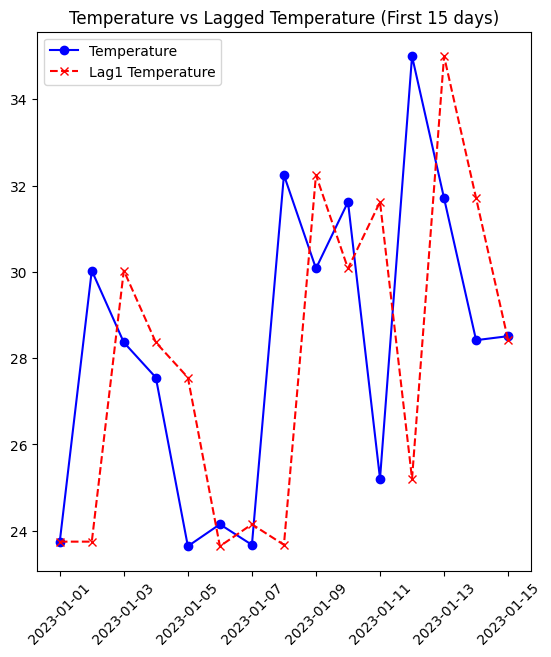

In [49]:
# Visualize a sample of the imputed data
plt.figure(figsize=(14, 7))

# Example: Original temperature vs lagged temperature
plt.subplot(1, 2, 1)
plt.plot(weather_df['date'].head(15), weather_df['avg_temperature'].head(15), 'b-o', label='Temperature')
if 'avg_temperature_lag1' in weather_df.columns:
    plt.plot(weather_df['date'].head(15), weather_df['avg_temperature_lag1'].head(15), 'r--x', label='Lag1 Temperature')
plt.title('Temperature vs Lagged Temperature (First 15 days)')
plt.legend()
plt.xticks(rotation=45)



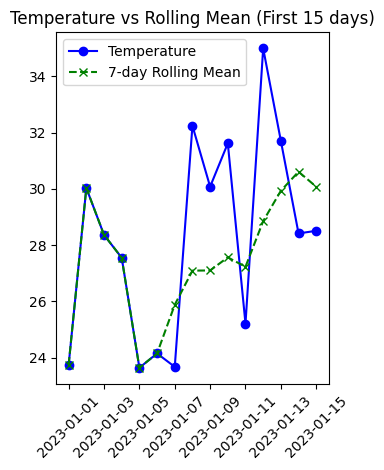


Time series feature engineering complete!


In [50]:
# Example: Original vs rolling mean
plt.subplot(1, 2, 2)
plt.plot(weather_df['date'].head(15), weather_df['avg_temperature'].head(15), 'b-o', label='Temperature')
if 'avg_temperature_rolling_7_mean' in weather_df.columns:
    plt.plot(weather_df['date'].head(15), weather_df['avg_temperature_rolling_7_mean'].head(15), 'g--x', label='7-day Rolling Mean')
plt.title('Temperature vs Rolling Mean (First 15 days)')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("\nTime series feature engineering complete!")

### **Data Validation**

In [ ]:
def validate_weather_data(df):
    """
    Validate physical constraints of weather variables and fix violations.
    """
    # Make a copy to compare before and after
    df_before = df.copy()
    violations_found = False
    
    # Define physical constraints for weather variables
    constraints = {
        'humidity': (0, 100, '%'),
        'avg_temperature': (-50, 60, '°C'),
        'avg_wind_speed': (0, 150, 'm/s'),
        'cloud_cover': (0, 100, '%'),
        'pressure': (900, 1100, 'hPa')
    }
    
    print("Running physical constraint validations...")
    
    # Check each variable against its constraints
    for var, (min_val, max_val, unit) in constraints.items():
        if var in df.columns:
            # Count values outside the valid range
            below_min = (df[var] < min_val).sum()
            above_max = (df[var] > max_val).sum()
            total_violations = below_min + above_max
            
            if total_violations > 0:
                violations_found = True
                print(f"\n Found {total_violations} records with {var} outside {min_val}-{max_val} {unit} range:")
                print(f"  - {below_min} below minimum")
                print(f"  - {above_max} above maximum")
                
                # Show example violations
                if below_min > 0:
                    print(f"  - Minimum value found: {df[var].min()} {unit}")
                if above_max > 0:
                    print(f"  - Maximum value found: {df[var].max()} {unit}")
                
                # Fix by clipping to valid range
                df[var] = df[var].clip(min_val, max_val)
                print(f"Fixed: Values have been clipped to {min_val}-{max_val} {unit}")
            else:
                print(f"{var} is within valid range ({min_val}-{max_val} {unit})")
    
    # Check for impossible relationships between variables
    if 'humidity' in df.columns and 'cloud_cover' in df.columns:
        # High humidity with zero cloud cover is suspicious
        suspicious = ((df['humidity'] > 95) & (df['cloud_cover'] < 10)).sum()
        if suspicious > 0:
            print(f"\n Found {suspicious} records with high humidity (>95%) but low cloud cover (<10%)")
            print("This combination is meteorologically unusual but not impossible.")
    
    # Check for impossible weather sequences
    if 'avg_temperature_delta' in df.columns:
        extreme_changes = (df['avg_temperature_delta'].abs() > 20).sum()
        if extreme_changes > 0:
            print(f"\n Found {extreme_changes} instances of temperature changing by >20°C in a single day")
            extreme_rows = df[df['avg_temperature_delta'].abs() > 20][['date', 'avg_temperature', 'avg_temperature_lag1', 'avg_temperature_delta']]
            print("Example of extreme temperature changes:")
            display(extreme_rows.head(3))
    
    # Provide summary of changes if violations were found
    if violations_found:
        print("\n=== Data Integrity Fix Summary ===")
        for var in constraints:
            if var in df.columns:
                before_range = f"[{df_before[var].min():.2f}, {df_before[var].max():.2f}]"
                after_range = f"[{df[var].min():.2f}, {df[var].max():.2f}]"
                print(f"{var}: {before_range} → {after_range}")
    else:
        print("\nAll weather variables are within valid physical constraints!")
    
    return df

# Run the validation on the weather dataset
weather_df = validate_weather_data(weather_df)



Running physical constraint validations...
humidity is within valid range (0-100 %)
avg_temperature is within valid range (-50-60 °C)
avg_wind_speed is within valid range (0-150 m/s)
cloud_cover is within valid range (0-100 %)
pressure is within valid range (900-1100 hPa)

 All weather variables are within valid physical constraints!


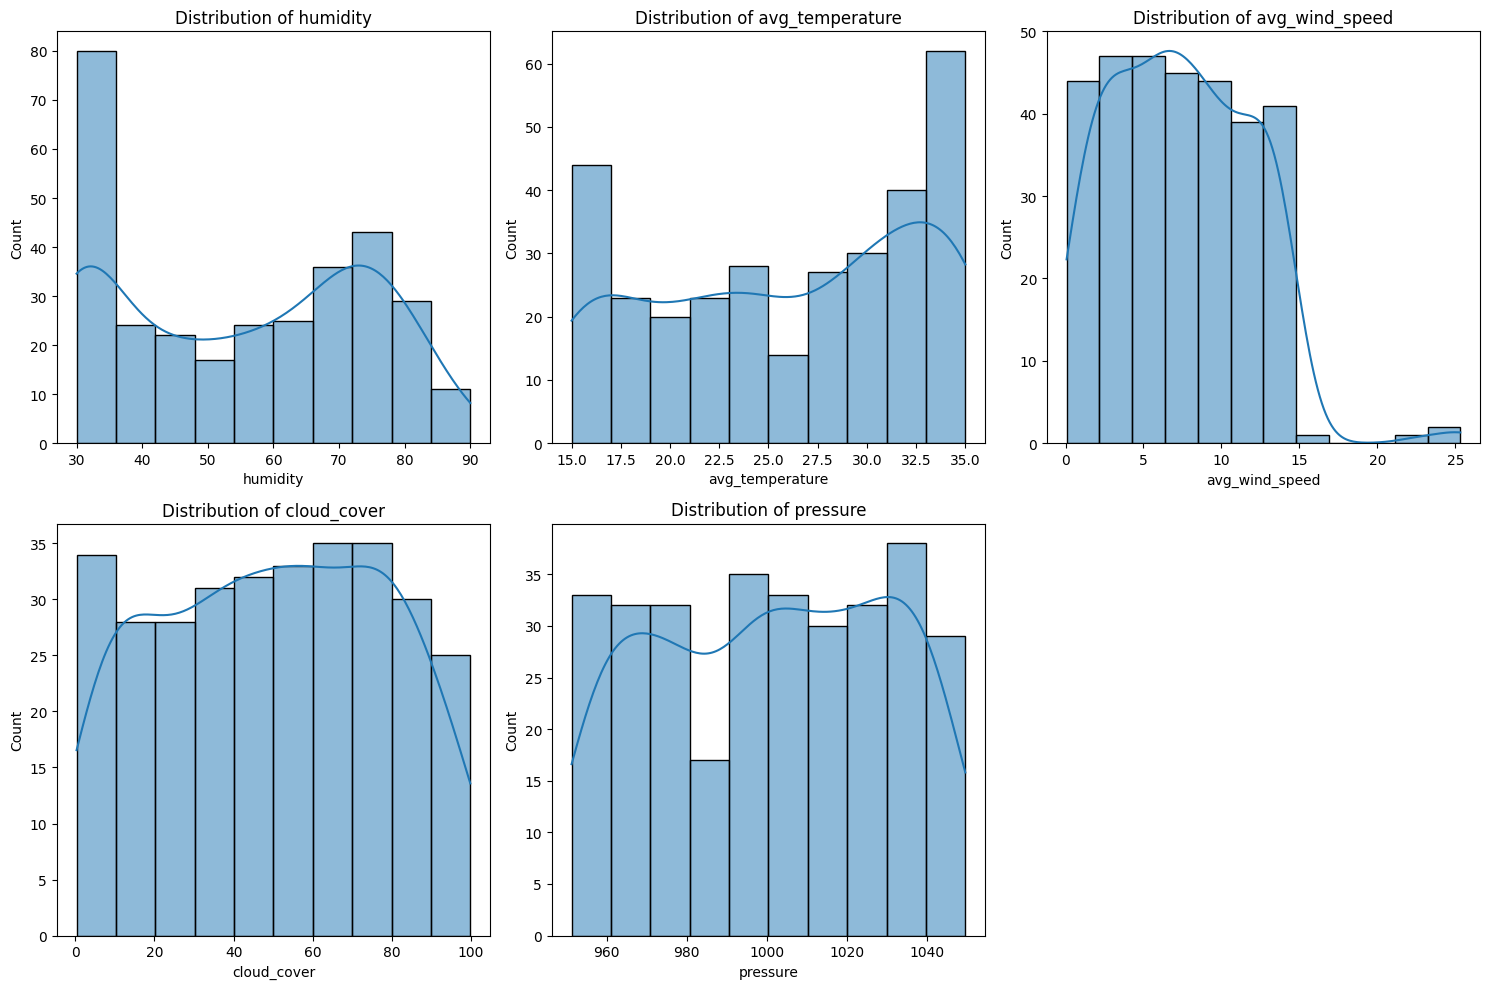

In [52]:

plt.figure(figsize=(15, 10))
constraint_vars = ['humidity', 'avg_temperature', 'avg_wind_speed', 'cloud_cover', 'pressure']
plot_count = 1

for var in constraint_vars:
    if var in weather_df.columns:
        plt.subplot(2, 3, plot_count)
        sns.histplot(weather_df[var], kde=True)
        plt.title(f'Distribution of {var}')
        plot_count += 1

plt.tight_layout()
plt.show()



In [53]:
# Check for other logical inconsistencies
print("\nChecking for other logical inconsistencies...")

# Rain without humidity/cloud patterns
if 'rain_or_not' in weather_df.columns and 'humidity' in weather_df.columns:
    rain_low_humidity = weather_df[(weather_df['rain_or_not'] == 1) & (weather_df['humidity'] < 30)].shape[0]
    if rain_low_humidity > 0:
        print(f"Found {rain_low_humidity} rainy days with unusually low humidity (<30%)")

# Calculate physical comfort index (optional)
if all(x in weather_df.columns for x in ['avg_temperature', 'humidity']):
    # Simple heat index calculation
    weather_df['heat_index'] = weather_df.apply(
        lambda x: x['avg_temperature'] + 0.05 * x['humidity'] if x['avg_temperature'] > 20 else x['avg_temperature'], 
        axis=1
    )
    print("\nAdded heat_index feature based on temperature and humidity")


Checking for other logical inconsistencies...

Added heat_index feature based on temperature and humidity


### **Target Variable Analysis**


Class distribution:
Rain: 198 samples (63.67%)
No Rain: 113 samples (36.33%)

Imbalance ratio (majority:minority): 1.75:1


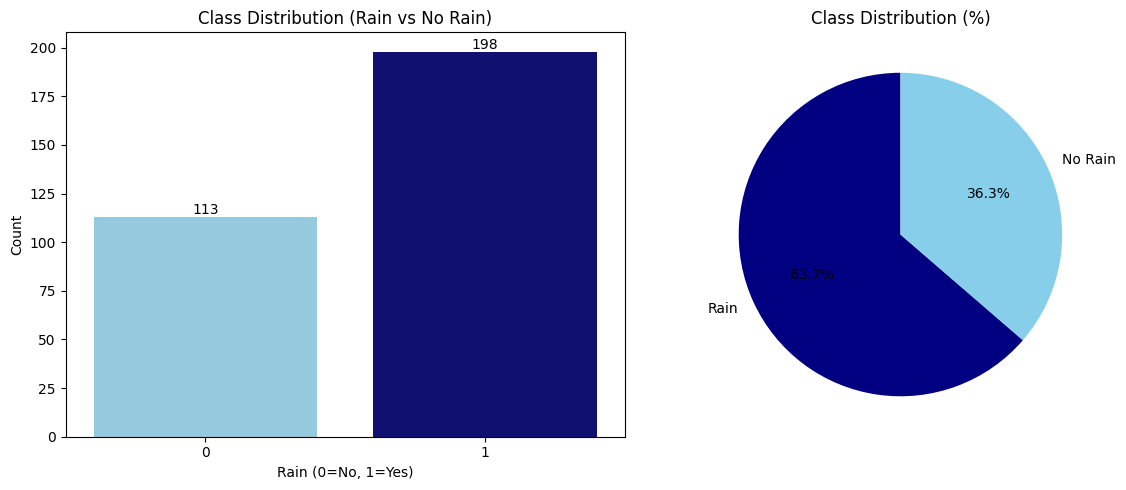

In [56]:
# Check class distribution in the target variable
class_counts = weather_df['rain_or_not'].value_counts()
class_percentages = weather_df['rain_or_not'].value_counts(normalize=True) * 100

print("\nClass distribution:")
for class_val, count in class_counts.items():
    label = "Rain" if class_val == 1 else "No Rain"
    print(f"{label}: {count} samples ({class_percentages[class_val]:.2f}%)")

# Calculate imbalance ratio
if len(class_counts) == 2:
    minority_class = class_counts.idxmin()
    majority_class = class_counts.idxmax()
    imbalance_ratio = class_counts[majority_class] / class_counts[minority_class]
    print(f"\nImbalance ratio (majority:minority): {imbalance_ratio:.2f}:1")

# Visualize class balance
plt.figure(figsize=(12, 5))

# Count plot
plt.subplot(1, 2, 1)
ax = sns.countplot(x='rain_or_not', data=weather_df, palette=['skyblue', 'navy'])
plt.title('Class Distribution (Rain vs No Rain)')
plt.xlabel('Rain (0=No, 1=Yes)')
plt.ylabel('Count')

# Add count labels on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width()/2., p.get_height()), 
                ha='center', va='bottom')

# Pie chart
plt.subplot(1, 2, 2)
plt.pie(class_counts, labels=['Rain', 'No Rain'] if 0 in class_counts.index else ['No Rain', 'Rain'],
        autopct='%1.1f%%', colors=['navy','skyblue'], startangle=90)
plt.title('Class Distribution (%)')

plt.tight_layout()
plt.show()



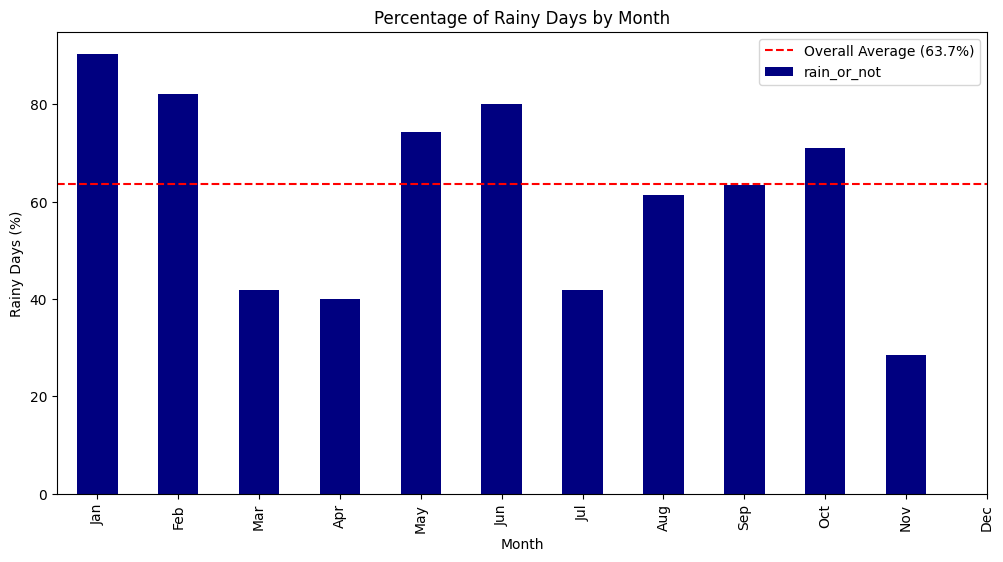

In [57]:
# Analyze class distribution over time
plt.figure(figsize=(12, 6))
monthly_rain = weather_df.groupby(weather_df['date'].dt.month)['rain_or_not'].mean() * 100
monthly_rain.plot(kind='bar', color='navy')
plt.title('Percentage of Rainy Days by Month')
plt.xlabel('Month')
plt.ylabel('Rainy Days (%)')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.axhline(y=weather_df['rain_or_not'].mean() * 100, color='r', linestyle='--', 
            label=f'Overall Average ({weather_df["rain_or_not"].mean()*100:.1f}%)')
plt.legend()
plt.show()



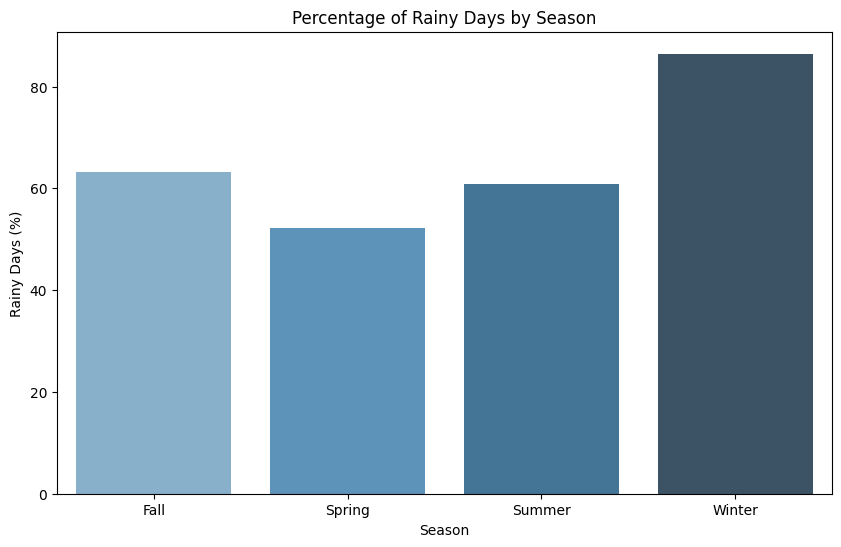

In [58]:
# Check class balance by season
if any(col.startswith('season_') for col in weather_df.columns):
    plt.figure(figsize=(10, 6))
    season_cols = [col for col in weather_df.columns if col.startswith('season_')]
    season_rain_rates = []
    season_names = []
    
    for col in season_cols:
        season_name = col.replace('season_', '')
        season_rain = weather_df[weather_df[col] == 1]['rain_or_not'].mean() * 100
        season_rain_rates.append(season_rain)
        season_names.append(season_name)
    
    seasons_df = pd.DataFrame({'Season': season_names, 'Rain_Percentage': season_rain_rates})
    sns.barplot(x='Season', y='Rain_Percentage', data=seasons_df, palette='Blues_d')
    plt.title('Percentage of Rainy Days by Season')
    plt.ylabel('Rainy Days (%)')
    plt.show()



### **Feature Selection With Correlation**

In [59]:
# Select numeric columns only - exclude date and categorical columns
numeric_df = weather_df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation = numeric_df.corr()

# Display correlations with the target variable (rain_or_not)
print("\nFeature correlation with rain_or_not (sorted):")
rain_correlation = correlation['rain_or_not'].sort_values(ascending=False)
print(rain_correlation.head(15))  # Show top 15 positively correlated features
print("\n")
print(rain_correlation.tail(5))   # Show top 5 negatively correlated features




Feature correlation with rain_or_not (sorted):
rain_or_not                       1.000000
rain_freq_3d                      0.625694
rain_freq_7d                      0.403409
humidity_rolling_3_min            0.323954
humidity_rolling_3_mean           0.322532
humidity                          0.321497
humidity_rolling_3_max            0.320288
humidity_lag1                     0.318201
humidity_rolling_7_min            0.315447
avg_temperature_rolling_7_min     0.315042
humidity_rolling_7_mean           0.308133
humidity_lag2                     0.307750
heat_index                        0.305997
avg_temperature                   0.298929
avg_temperature_rolling_7_mean    0.298039
Name: rain_or_not, dtype: float64


cloud_cover_rolling_3_max      -0.115462
avg_wind_speed_lag2            -0.116252
avg_wind_speed_rolling_3_std   -0.123863
cloud_cover_rolling_7_max      -0.151669
year                                 NaN
Name: rain_or_not, dtype: float64


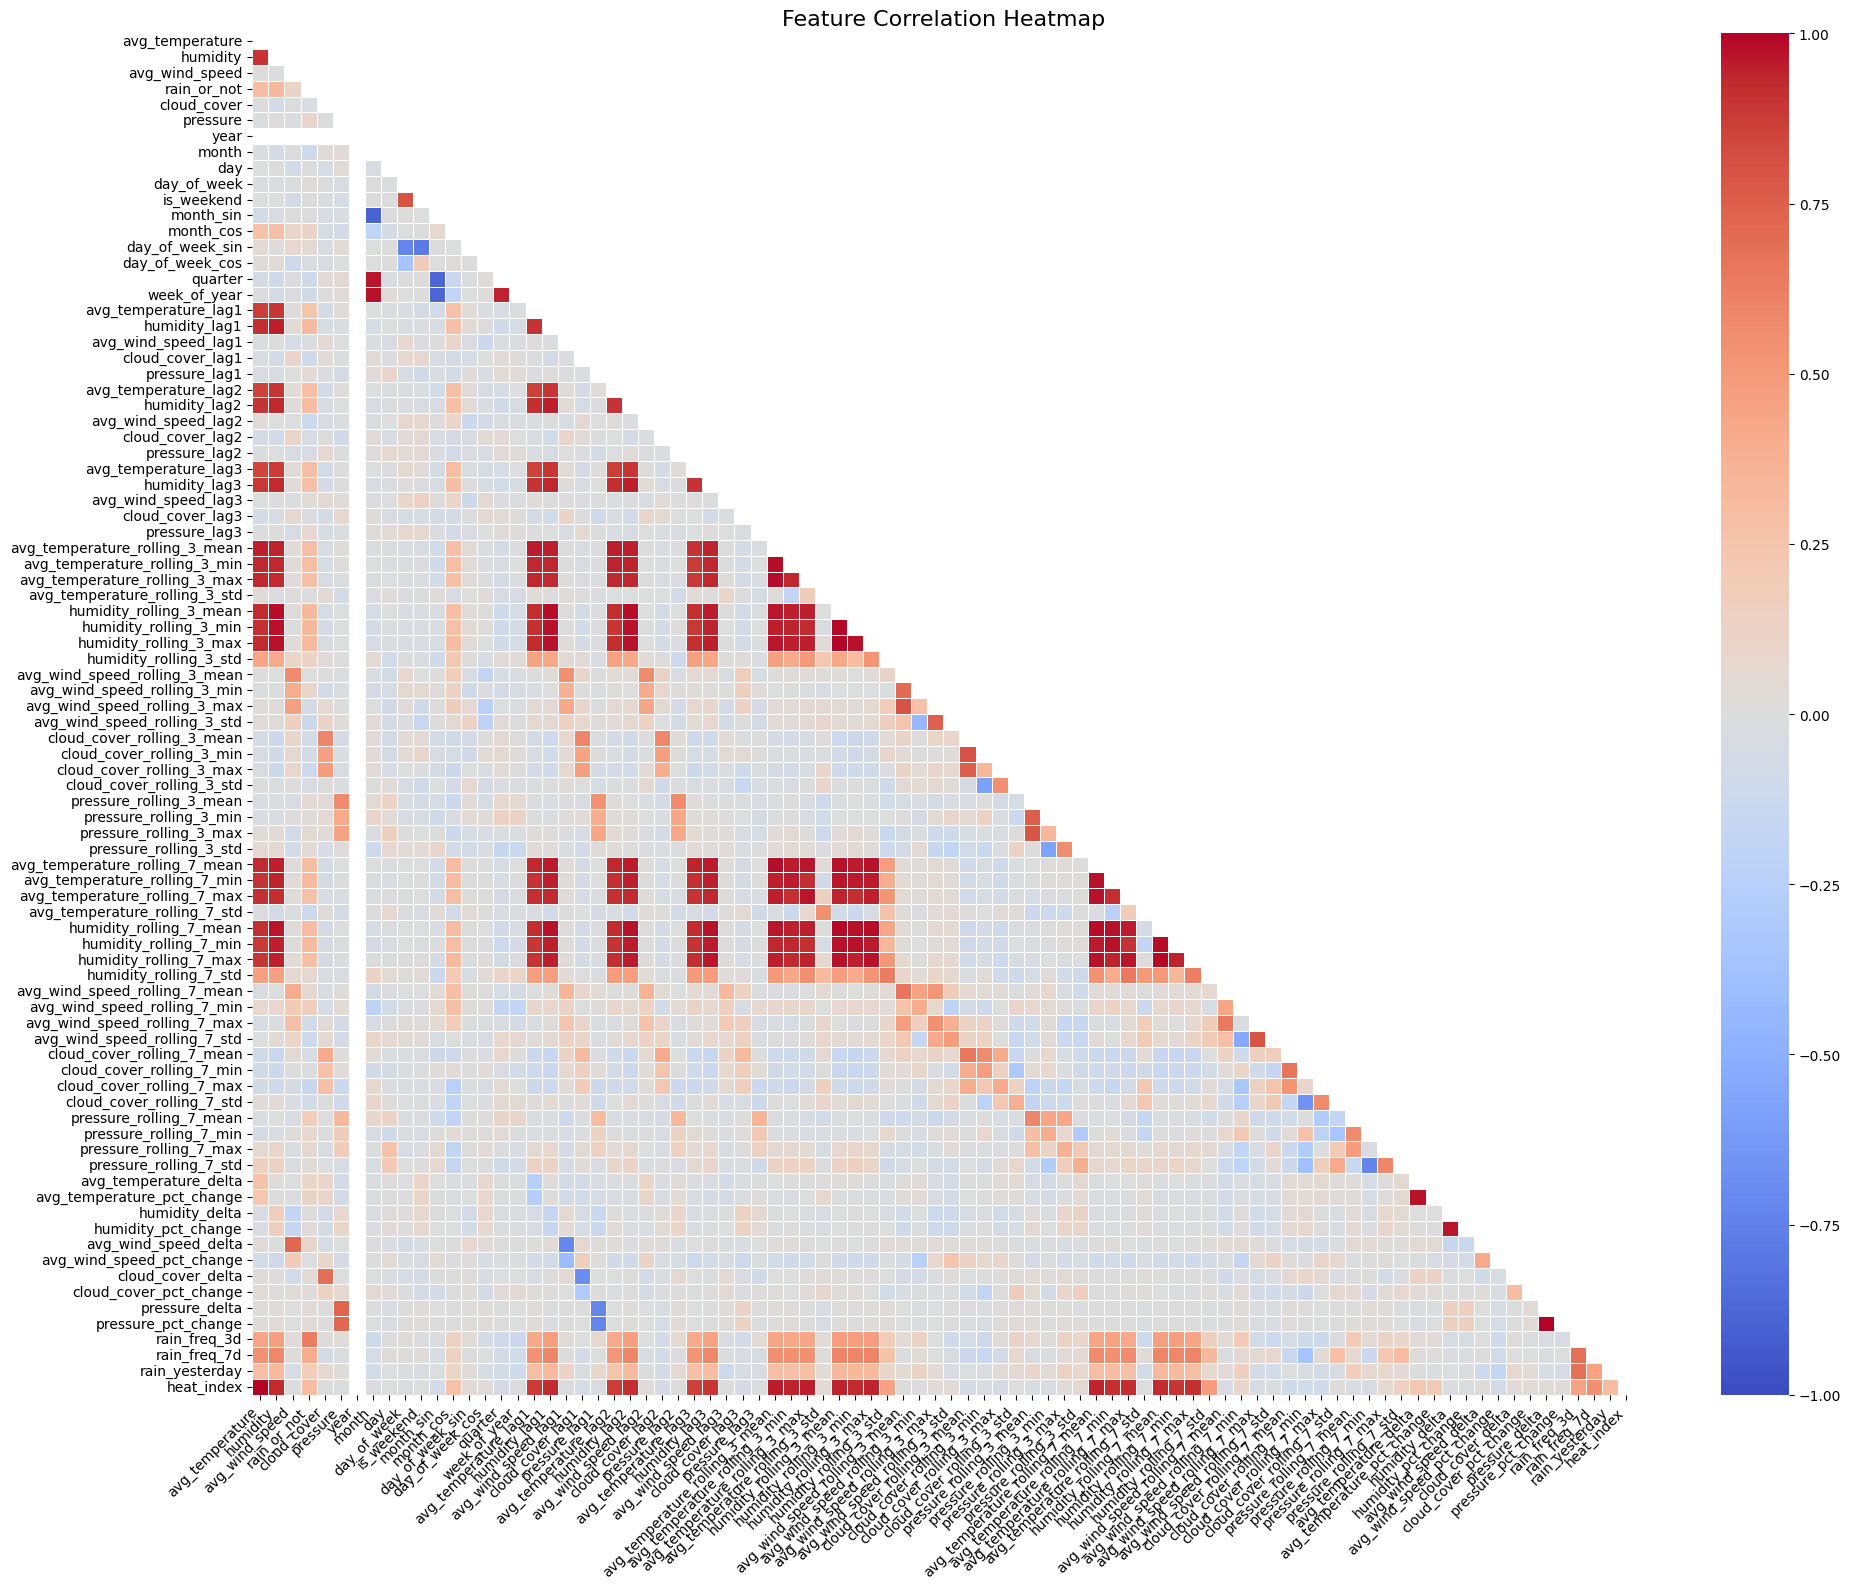

In [60]:
# Create correlation heatmap
plt.figure(figsize=(20, 16))
mask = np.triu(correlation)
sns.heatmap(correlation, annot=False, cmap='coolwarm', mask=mask,
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



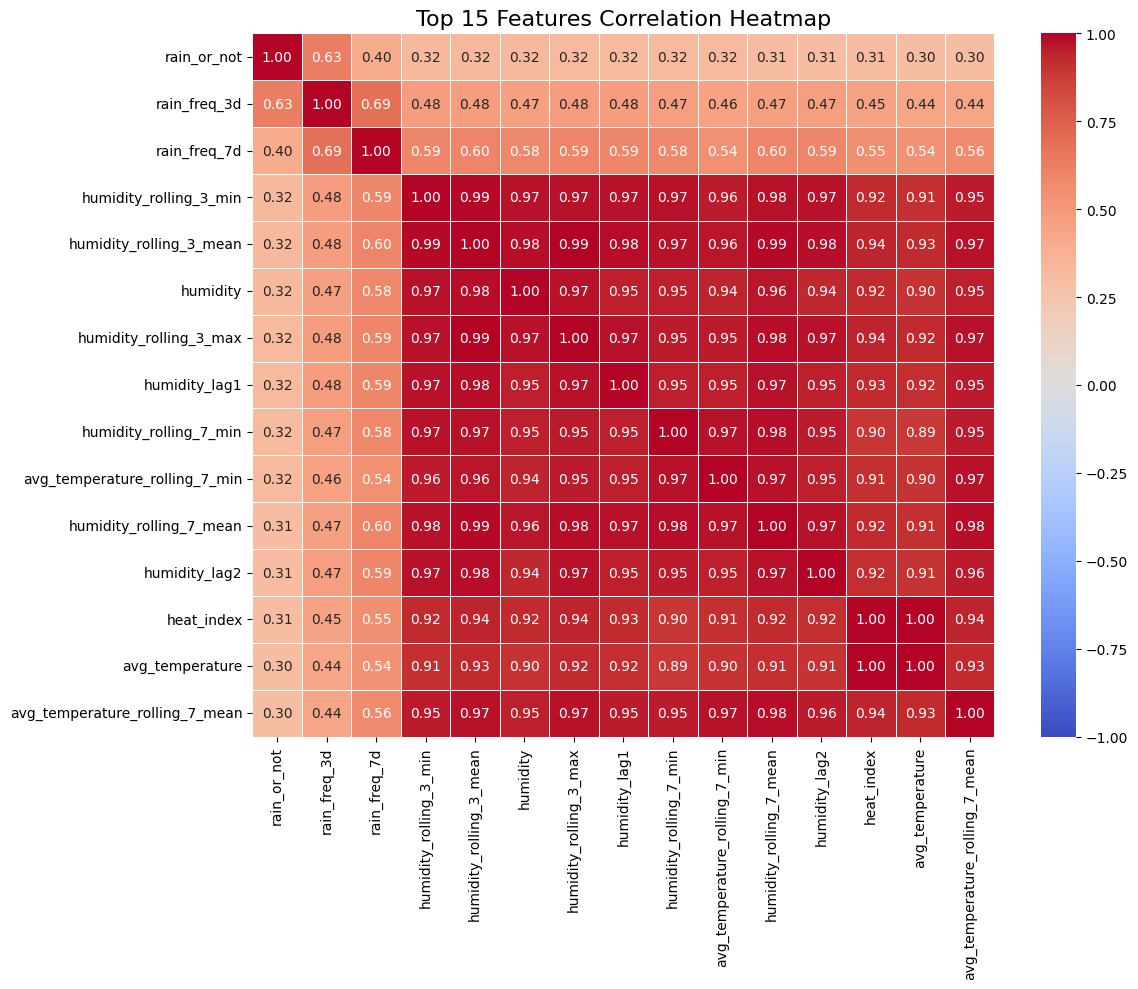

In [61]:
# Focus on features most correlated with rain (absolute value)
rain_corr_abs = correlation['rain_or_not'].abs().sort_values(ascending=False)
top_features = rain_corr_abs.head(15).index.tolist()

# Create a focused correlation heatmap with only the top features
plt.figure(figsize=(12, 10))
focused_corr = correlation.loc[top_features, top_features]
sns.heatmap(focused_corr, annot=True, cmap='coolwarm', fmt='.2f',
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('Top 15 Features Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()



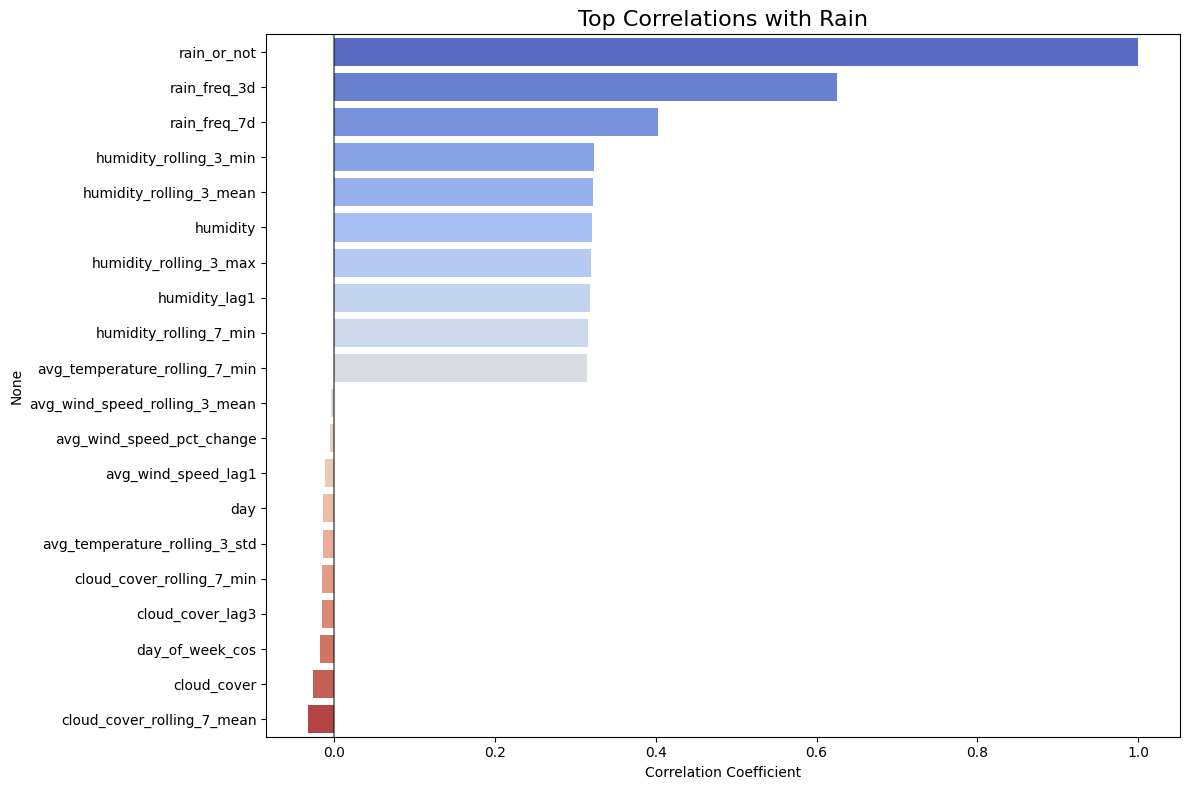

In [62]:
# Visualize top positive and negative correlations with rain
plt.figure(figsize=(12, 8))
top_pos = rain_correlation[rain_correlation > 0].head(10)
top_neg = rain_correlation[rain_correlation < 0].head(10)
top_combined = pd.concat([top_pos, top_neg])

# Create horizontal bar chart
sns.barplot(x=top_combined.values, y=top_combined.index, palette='coolwarm')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
plt.title('Top Correlations with Rain', fontsize=16)
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()



In [63]:
# Check for multicollinearity
print("\nChecking for multicollinearity among top features...")
high_corr_pairs = []
for i in range(len(top_features)):
    for j in range(i+1, len(top_features)):
        if i != j:  # Skip comparing feature with itself
            feature1 = top_features[i]
            feature2 = top_features[j]
            corr_value = abs(correlation.loc[feature1, feature2])
            
            if corr_value > 0.8 and feature1 != 'rain_or_not' and feature2 != 'rain_or_not':
                high_corr_pairs.append((feature1, feature2, corr_value))

# Display highly correlated feature pairs
if high_corr_pairs:
    print("\nHighly correlated feature pairs (|r| > 0.8):")
    for f1, f2, corr in sorted(high_corr_pairs, key=lambda x: x[2], reverse=True):
        print(f"- {f1} and {f2}: {corr:.3f}")
    
    print("\nConsider removing one feature from each highly correlated pair to reduce multicollinearity.")
else:
    print("\nNo severe multicollinearity detected among top features.")

# Feature selection based on correlation threshold
print("\nFeature selection based on correlation:")

# Select features with absolute correlation > 0.1 with target
selected_features = rain_corr_abs[rain_corr_abs > 0.1].index.tolist()
selected_features.remove('rain_or_not')  # Remove target from features list

print(f"Selected {len(selected_features)} features with |correlation| > 0.1 with rain_or_not:")
print(selected_features)


Checking for multicollinearity among top features...

Highly correlated feature pairs (|r| > 0.8):
- heat_index and avg_temperature: 0.998
- humidity_rolling_3_mean and humidity_rolling_3_max: 0.992
- humidity_rolling_3_min and humidity_rolling_3_mean: 0.990
- humidity_rolling_3_mean and humidity_rolling_7_mean: 0.987
- humidity_rolling_7_mean and avg_temperature_rolling_7_mean: 0.983
- humidity_rolling_3_mean and humidity_lag1: 0.983
- humidity_rolling_3_max and humidity_rolling_7_mean: 0.982
- humidity_rolling_3_mean and humidity: 0.980
- humidity_rolling_7_min and humidity_rolling_7_mean: 0.980
- humidity_rolling_3_mean and humidity_lag2: 0.980
- humidity_rolling_3_min and humidity_rolling_7_mean: 0.975
- humidity_rolling_3_max and humidity_lag1: 0.974
- humidity_rolling_3_max and humidity_lag2: 0.974
- humidity_rolling_3_min and humidity_rolling_7_min: 0.974
- humidity_rolling_7_mean and humidity_lag2: 0.973
- humidity_rolling_3_max and avg_temperature_rolling_7_mean: 0.973
- humi

### **Feature Scaling**

In [64]:
# Create a scaled copy of the dataframe to preserve the original data
weather_df_scaled = weather_df.copy()

# Identify numerical features to scale (exclude target, date, and binary/categorical columns)
exclude_cols = ['date', 'rain_or_not', 'rain_yesterday', 'is_weekend'] 
exclude_cols += [col for col in weather_df.columns if col.startswith('season_')]

# Select only numeric columns for scaling
features_to_scale = [col for col in weather_df.columns if 
                     col not in exclude_cols and 
                     weather_df[col].dtype in ['int64', 'float64']]

print(f"\nScaling {len(features_to_scale)} numerical features:")
print(f"First 10 features to scale: {features_to_scale[:10]}")

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the selected features
weather_df_scaled[features_to_scale] = scaler.fit_transform(weather_df[features_to_scale])

# Display before and after statistics for a sample of scaled features
sample_features = features_to_scale[:5]  # Take first 5 features as sample
print("\nScaling effect (before vs. after):")
for feature in sample_features:
    before_mean = weather_df[feature].mean()
    before_std = weather_df[feature].std()
    after_mean = weather_df_scaled[feature].mean()
    after_std = weather_df_scaled[feature].std()
    
    print(f"{feature}:")
    print(f"  Before: mean = {before_mean:.3f}, std = {before_std:.3f}")
    print(f"  After:  mean = {after_mean:.3f}, std = {after_std:.3f}")


# Save the scaler for future use (e.g., for test data)
import pickle
with open('weather_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)
print("\nScaler saved as 'weather_scaler.pkl' for future use")

# Create a function to apply the same scaling to new data
def scale_new_data(new_data, scaler_path='weather_scaler.pkl'):
    """
    Scale new weather data using the saved scaler
    
    Parameters:
    -----------
    new_data : DataFrame with the same features as the training data
    scaler_path : path to the saved scaler pickle file
    
    Returns:
    --------
    DataFrame with scaled features
    """
    # Load the scaler
    with open(scaler_path, 'rb') as file:
        scaler = pickle.load(file)
    
    # Copy the dataframe
    scaled_data = new_data.copy()
    
    # Apply scaling to the same features
    scaled_data[features_to_scale] = scaler.transform(new_data[features_to_scale])
    
    return scaled_data



Scaling 77 numerical features:
First 10 features to scale: ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure', 'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos', 'avg_temperature_lag1']

Scaling effect (before vs. after):
avg_temperature:
  Before: mean = 26.068, std = 6.761
  After:  mean = -0.000, std = 1.002
humidity:
  Before: mean = 55.311, std = 19.090
  After:  mean = -0.000, std = 1.002
avg_wind_speed:
  Before: mean = 7.418, std = 4.510
  After:  mean = 0.000, std = 1.002
cloud_cover:
  Before: mean = 49.673, std = 28.438
  After:  mean = 0.000, std = 1.002
pressure:
  Before: mean = 1001.059, std = 28.836
  After:  mean = 0.000, std = 1.002

Scaler saved as 'weather_scaler.pkl' for future use


### **Split Data Train and Test**

In [65]:
# Ensure data is sorted by date
weather_df = weather_df.sort_values('date').reset_index(drop=True)

# Define train-test split ratio (using the last 20% for testing)
train_size = 0.8
split_idx = int(len(weather_df) * train_size)

# Split the data
train_df = weather_df.iloc[:split_idx]
test_df = weather_df.iloc[split_idx:]

print("\nTime-based train-test split:")
print(f"Training data: {len(train_df)} samples ({train_size*100:.0f}%)")
print(f"  Date range: {train_df['date'].min().date()} to {train_df['date'].max().date()}")
print(f"Testing data: {len(test_df)} samples ({(1-train_size)*100:.0f}%)")
print(f"  Date range: {test_df['date'].min().date()} to {test_df['date'].max().date()}")

# Check class distribution in both splits
train_rain_pct = train_df['rain_or_not'].mean() * 100
test_rain_pct = test_df['rain_or_not'].mean() * 100

print("\nClass distribution:")
print(f"  Training: {train_rain_pct:.1f}% rainy days")
print(f"  Testing:  {test_rain_pct:.1f}% rainy days")




Time-based train-test split:
Training data: 248 samples (80%)
  Date range: 2023-01-01 to 2023-09-05
Testing data: 63 samples (20%)
  Date range: 2023-09-06 to 2023-11-07

Class distribution:
  Training: 63.3% rainy days
  Testing:  65.1% rainy days


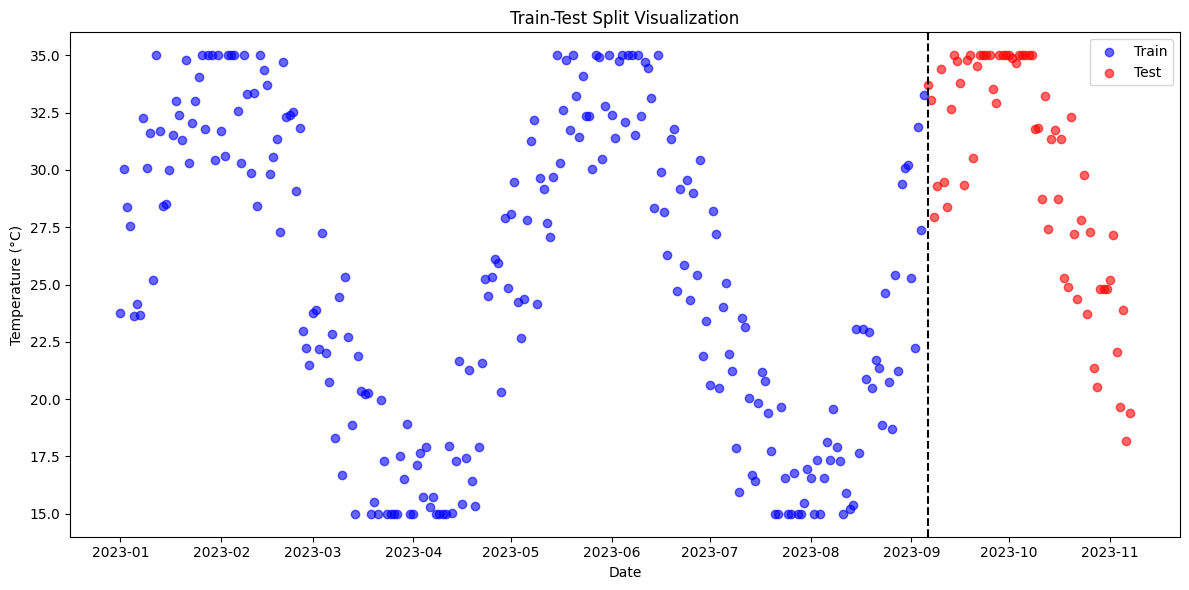

In [66]:
# Visualize the train-test split
plt.figure(figsize=(12, 6))

# Plot temperature over time with train/test split
plt.scatter(train_df['date'], train_df['avg_temperature'], 
           color='blue', alpha=0.6, label='Train')
plt.scatter(test_df['date'], test_df['avg_temperature'], 
           color='red', alpha=0.6, label='Test')

plt.axvline(x=test_df['date'].min(), color='black', linestyle='--')
plt.title('Train-Test Split Visualization')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.tight_layout()
plt.show()



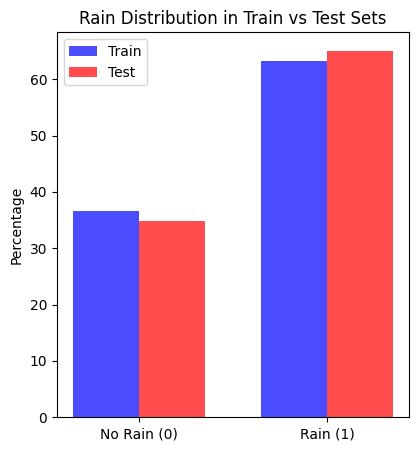

In [67]:
# Visualize rain distribution in both splits
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
train_rain = train_df['rain_or_not'].value_counts(normalize=True) * 100
test_rain = test_df['rain_or_not'].value_counts(normalize=True) * 100

# Bar chart comparing rain distribution
x = np.arange(2)
width = 0.35

plt.bar(x - width/2, [train_rain.get(0, 0), train_rain.get(1, 0)], 
        width, label='Train', color='blue', alpha=0.7)
plt.bar(x + width/2, [test_rain.get(0, 0), test_rain.get(1, 0)], 
        width, label='Test', color='red', alpha=0.7)

plt.ylabel('Percentage')
plt.title('Rain Distribution in Train vs Test Sets')
plt.xticks(x, ['No Rain (0)', 'Rain (1)'])
plt.legend()



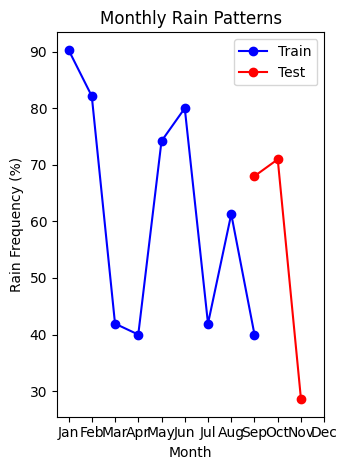


Data ready for modeling:
X_train shape: (248, 90)
X_test shape: (63, 90)


In [70]:
# Monthly rain distribution comparison
plt.subplot(1, 2, 2)
train_monthly = train_df.groupby(train_df['date'].dt.month)['rain_or_not'].mean() * 100
test_monthly = test_df.groupby(test_df['date'].dt.month)['rain_or_not'].mean() * 100

train_monthly.plot(kind='line', marker='o', color='blue', label='Train')
test_monthly.plot(kind='line', marker='o', color='red', label='Test')
plt.title('Monthly Rain Patterns')
plt.xlabel('Month')
plt.ylabel('Rain Frequency (%)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()

plt.tight_layout()
plt.show()

# Separate features and target
X_train = train_df.drop(['date', 'rain_or_not'], axis=1)
y_train = train_df['rain_or_not']
X_test = test_df.drop(['date', 'rain_or_not'], axis=1)
y_test = test_df['rain_or_not']

# Make sure all columns match between train and test
train_cols = set(X_train.columns)
test_cols = set(X_test.columns)

if train_cols != test_cols:
    print("\nWarning: Column mismatch between train and test sets!")
    print(f"Columns only in train: {train_cols - test_cols}")
    print(f"Columns only in test: {test_cols - train_cols}")
    
    # Ensure same columns
    common_cols = list(train_cols.intersection(test_cols))
    X_train = X_train[common_cols]
    X_test = X_test[common_cols]
    
    print(f"Using {len(common_cols)} common columns for modeling")

print("\nData ready for modeling:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# # Save split data for later use
# train_df.to_csv('../Data-Set/processed_data/weather_train.csv', index=False)
# test_df.to_csv('../Data-Set/processed_data/weather_test.csv', index=False)
# print("\nSplit data saved as 'weather_train.csv' and 'weather_test.csv'")

### **One-hot Encode the categorical variable**

In [71]:

# Step 1: Separate date and target from features
X_train = train_df.drop(['date', 'rain_or_not'], axis=1)
y_train = train_df['rain_or_not']
X_test = test_df.drop(['date', 'rain_or_not'], axis=1)
y_test = test_df['rain_or_not']

# Step 2: Handle all categorical variables
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns to encode: {categorical_cols}")

# One-hot encode all categorical columns
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=False)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=False)

# Step 3: Ensure train and test have the same columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Step 4: Convert ALL columns to standard numpy float64 types
# This is the key fix - prevents integer dtype conversion issues after SMOTE
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)

print("All columns converted to float64 to ensure compatibility with SMOTE")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")



Categorical columns to encode: ['day_name']
All columns converted to float64 to ensure compatibility with SMOTE
X_train shape: (248, 96)
X_test shape: (63, 96)


In [79]:

# Combine the resampled features and target into a single DataFrame
train_resampled = X_train.copy()
train_resampled['rain_or_not'] = y_train

# Save to CSV
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)
test_df_final = X_test_df.copy()
test_df_final['rain_or_not'] = y_test
test_df_final.to_csv('../Data-Set/processed_data/final/weather_test_processed.csv', index=False)


print("Processed test data saved as 'weather_test_processed.csv'")

# Option 2: Save both original and resampled versions
# This is useful to have both versions available
# Create original version of processed training data
train_original = X_train.copy()
train_original['rain_or_not'] = y_train
train_original.to_csv('../Data-Set/processed_data/final/weather_train_original.csv', index=False)

print("\nOriginal training data saved as 'weather_train_original.csv'")

# Option 3: Save with dates included
# If you need dates in your final datasets, add them back
if 'date' in train_df.columns:
    # For original training data with dates
    train_with_dates = train_original.copy()
    train_dates = train_df['date'].reset_index(drop=True)
    train_with_dates.insert(0, 'date', train_dates)
    train_with_dates.to_csv('../Data-Set/processed_data/final/weather_train_with_dates.csv', index=False)
    
    # For test data with dates
    test_with_dates = test_df_final.copy()
    test_dates = test_df['date'].reset_index(drop=True)
    test_with_dates.insert(0, 'date', test_dates)
    test_with_dates.to_csv('../Data-Set/processed_data/final/weather_test_with_dates.csv', index=False)
    
    print("Datasets with date columns saved")

print("\nAll processed datasets have been saved successfully!")

Processed test data saved as 'weather_test_processed.csv'

Original training data saved as 'weather_train_original.csv'
Datasets with date columns saved

All processed datasets have been saved successfully!


### **Feature Selection**


Running quick feature importance analysis...
Using original training data for feature importance
Random Forest trained in 0.16 seconds

Top 10 features by importance:
                           Feature  Importance
85                    rain_freq_3d    0.059967
55  avg_temperature_rolling_7_mean    0.020804
1                         humidity    0.020652
79            avg_wind_speed_delta    0.019330
25            avg_temperature_lag2    0.018830
46    avg_wind_speed_rolling_3_std    0.018645
29                   pressure_lag2    0.018492
43   avg_wind_speed_rolling_3_mean    0.018281
59         humidity_rolling_7_mean    0.018277
2                   avg_wind_speed    0.017623

Calculating permutation importance...
Permutation importance calculated in 8.38 seconds

Top 10 features by permutation importance:
                          Feature  Importance
85                   rain_freq_3d    0.005645
0                 avg_temperature    0.000000
60         humidity_rolling_7_min    0.00000

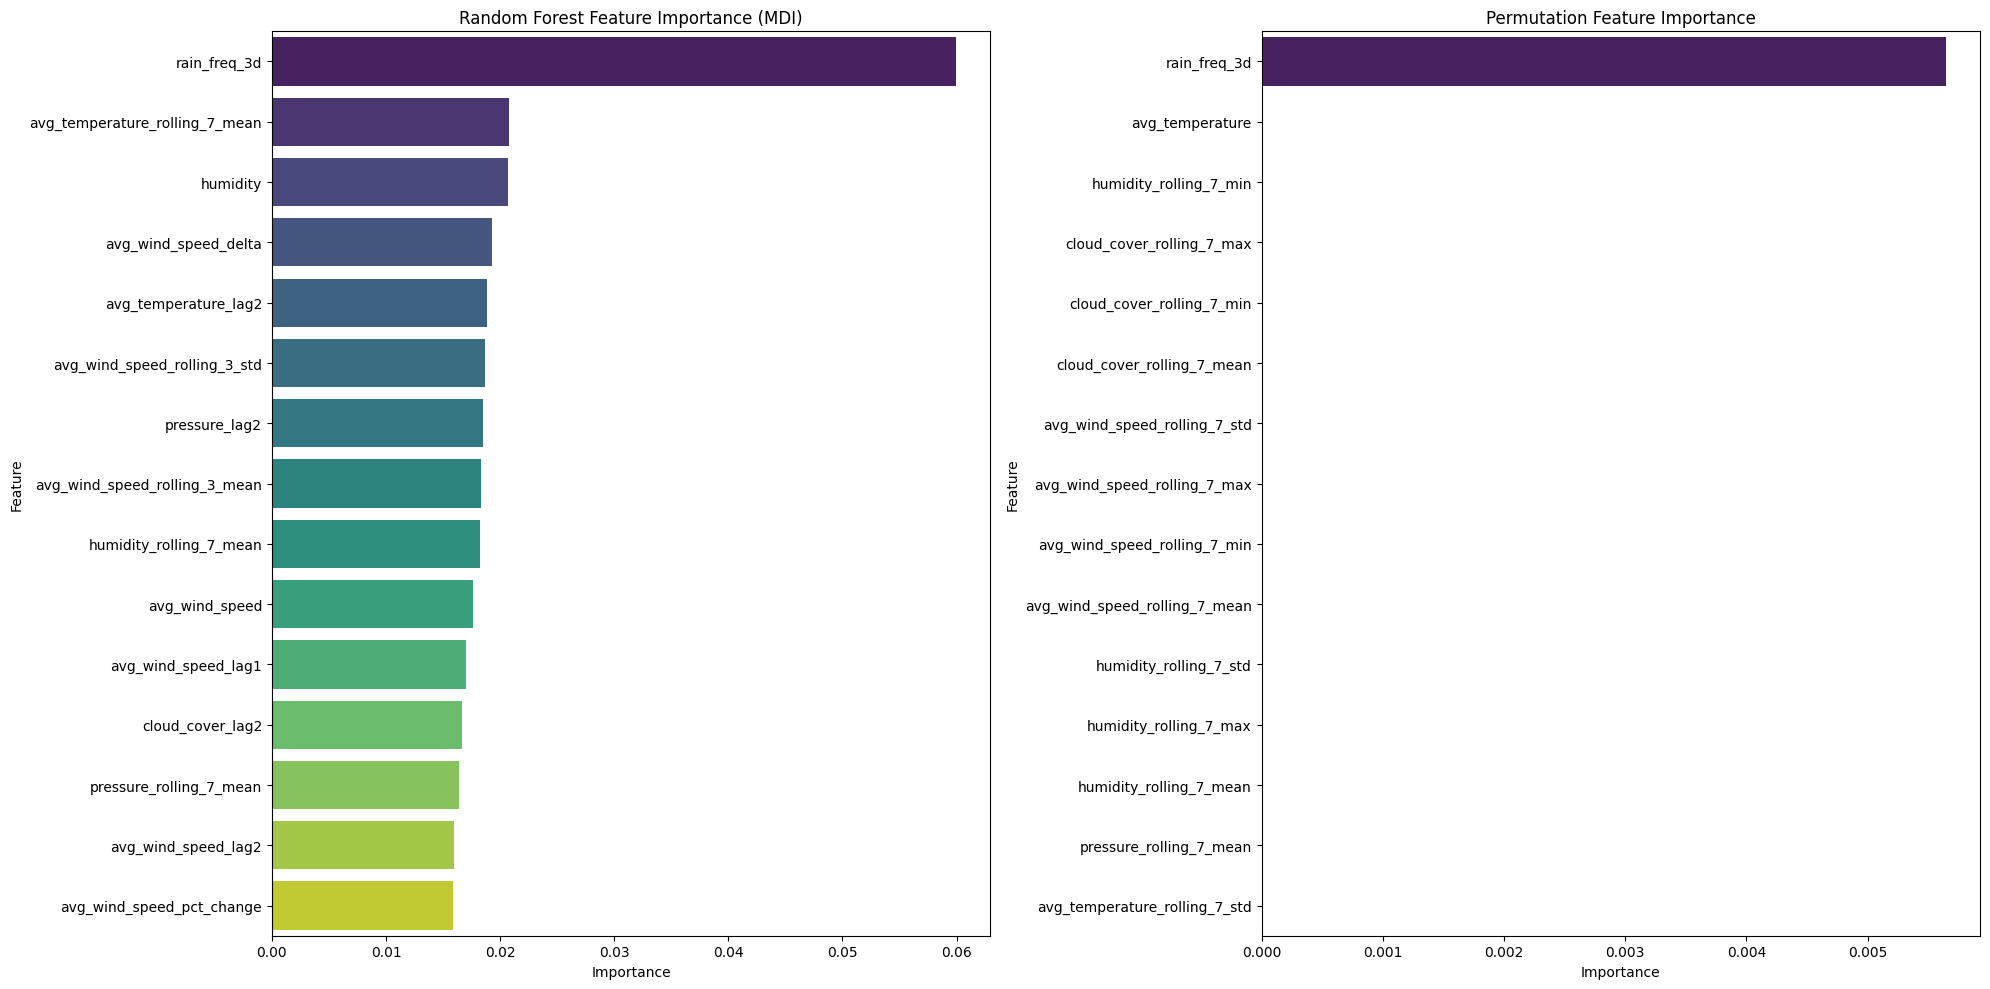

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time

print("\nRunning quick feature importance analysis...")

# Prepare data - use processed versions
# If we've applied SMOTE:
if 'X_train_resampled' in locals():
    X_train_check = X_train_resampled
    y_train_check = y_train_resampled
    print("Using SMOTE-resampled data for feature importance")
else:
    # Otherwise use the regular processed data
    X_train_check = X_train
    y_train_check = y_train
    print("Using original training data for feature importance")

# Train a quick random forest
start_time = time.time()
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_check, y_train_check)
training_time = time.time() - start_time
print(f"Random Forest trained in {training_time:.2f} seconds")

# Get built-in feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train_check.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 features by importance:")
print(feature_importance.head(10))

# Calculate permutation importance (more reliable but slower)
print("\nCalculating permutation importance...")
start_time = time.time()
perm_importance = permutation_importance(
    rf, X_train_check, y_train_check, 
    n_repeats=5, random_state=42, n_jobs=-1
)
permutation_time = time.time() - start_time
print(f"Permutation importance calculated in {permutation_time:.2f} seconds")

# Create DataFrame for permutation importance
perm_importance_df = pd.DataFrame({
    'Feature': X_train_check.columns,
    'Importance': perm_importance.importances_mean
}).sort_values('Importance', ascending=False)

print("\nTop 10 features by permutation importance:")
print(perm_importance_df.head(10))

# Plot both types of feature importance
plt.figure(figsize=(20, 10))

# Plot standard feature importance
plt.subplot(1, 2, 1)
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15), palette='viridis')
plt.title('Random Forest Feature Importance (MDI)')
plt.tight_layout()

# Plot permutation importance
plt.subplot(1, 2, 2)
sns.barplot(x='Importance', y='Feature', data=perm_importance_df.head(15), palette='viridis')
plt.title('Permutation Feature Importance')
plt.tight_layout()

plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



In [77]:
# Group similar features
print("\nFeature categories:")
feature_categories = {
    'Temperature': [col for col in X_train_check.columns if 'temperature' in col.lower()],
    'Humidity': [col for col in X_train_check.columns if 'humidity' in col.lower()],
    'Wind': [col for col in X_train_check.columns if 'wind' in col.lower()],
    'Pressure': [col for col in X_train_check.columns if 'pressure' in col.lower()],
    'Cloud': [col for col in X_train_check.columns if 'cloud' in col.lower()],
    'Time/Date': [col for col in X_train_check.columns if any(x in col.lower() for x in ['day', 'month', 'week', 'season'])],
    'Rain History': [col for col in X_train_check.columns if 'rain' in col.lower()]
}

# Print importance by category
for category, features in feature_categories.items():
    if features:
        category_importance = feature_importance[feature_importance['Feature'].isin(features)]
        total_importance = category_importance['Importance'].sum()
        print(f"{category}: {total_importance:.4f} total importance ({len(features)} features)")
        # Show top 3 in each category
        print("  Top features in this category:")
        for i, row in category_importance.head(3).iterrows():
            print(f"  - {row['Feature']}: {row['Importance']:.4f}")

# Final Stats Summary
print("\n--- Feature Importance Analysis Summary ---")
print(f"Total features analyzed: {len(X_train_check.columns)}")
print(f"Most important feature: {feature_importance.iloc[0]['Feature']} ({feature_importance.iloc[0]['Importance']:.4f})")
print(f"Least important feature: {feature_importance.iloc[-1]['Feature']} ({feature_importance.iloc[-1]['Importance']:.4f})")
print(f"Top 5 features account for {feature_importance.head(5)['Importance'].sum()*100:.1f}% of total importance")
print("------------------------------------------")




Feature categories:
Temperature: 0.1697 total importance (14 features)
  Top features in this category:
  - avg_temperature_rolling_7_mean: 0.0208
  - avg_temperature_lag2: 0.0188
  - avg_temperature_rolling_3_mean: 0.0149
Humidity: 0.1663 total importance (14 features)
  Top features in this category:
  - humidity: 0.0207
  - humidity_rolling_7_mean: 0.0183
  - humidity_rolling_3_mean: 0.0158
Wind: 0.2081 total importance (14 features)
  Top features in this category:
  - avg_wind_speed_delta: 0.0193
  - avg_wind_speed_rolling_3_std: 0.0186
  - avg_wind_speed_rolling_3_mean: 0.0183
Pressure: 0.1548 total importance (14 features)
  Top features in this category:
  - pressure_lag2: 0.0185
  - pressure_rolling_7_mean: 0.0164
  - pressure: 0.0136
Cloud: 0.1593 total importance (14 features)
  Top features in this category:
  - cloud_cover_lag2: 0.0167
  - cloud_cover_rolling_7_std: 0.0153
  - cloud_cover_lag3: 0.0143
Time/Date: 0.0550 total importance (21 features)
  Top features in this

In [78]:
# Feature recommendation
print("\nFeature recommendations:")
if len(X_train_check.columns) > 30:
    print("- Consider using a subset of the top 20-30 features for simpler models")

redundant_threshold = 0.95
high_corr_pairs = []
for i, row1 in feature_importance.head(20).iterrows():
    feature1 = row1['Feature']
    for j, row2 in feature_importance.head(20).iterrows():
        feature2 = row2['Feature']
        if feature1 != feature2:
            corr = abs(np.corrcoef(
                X_train_check[feature1].values, 
                X_train_check[feature2].values
            )[0, 1])
            if corr > redundant_threshold:
                high_corr_pairs.append((feature1, feature2, corr))

if high_corr_pairs:
    print("- Consider removing one feature from these highly correlated pairs:")
    for f1, f2, corr in high_corr_pairs:
        print(f"  * {f1} and {f2} are correlated at {corr:.3f}")

print("\nFeature importance analysis completed!")


Feature recommendations:
- Consider using a subset of the top 20-30 features for simpler models
- Consider removing one feature from these highly correlated pairs:
  * avg_temperature_rolling_7_mean and humidity_rolling_7_mean are correlated at 0.984
  * avg_temperature_rolling_7_mean and humidity_rolling_3_mean are correlated at 0.973
  * avg_temperature_rolling_7_mean and avg_temperature_rolling_3_mean are correlated at 0.978
  * humidity and humidity_rolling_7_mean are correlated at 0.966
  * humidity and humidity_rolling_3_mean are correlated at 0.983
  * avg_temperature_lag2 and avg_temperature_rolling_3_mean are correlated at 0.952
  * humidity_rolling_7_mean and avg_temperature_rolling_7_mean are correlated at 0.984
  * humidity_rolling_7_mean and humidity are correlated at 0.966
  * humidity_rolling_7_mean and humidity_rolling_3_mean are correlated at 0.988
  * humidity_rolling_7_mean and avg_temperature_rolling_3_mean are correlated at 0.961
  * humidity_rolling_3_mean and av